In [1]:
# import required libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Gathering

In [ ]:
url = "https://bikekharido.in/used-bikes-in-india/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.162 Safari/537.36"
}
response = requests.get(url,headers)

In [ ]:
soup = BeautifulSoup(response.text,"lxml")

In [ ]:
# name of bike
soup.find_all('h2',class_ = "fl-post-title-old bikeListHead")

In [ ]:
#price of bike 
soup.find_all(class_ = "fw500 spanblock fsize17 fcblack")

In [ ]:
page_length = 24

In [ ]:
#other info about the bikes
soup.find_all(class_ = "boxlabel imptags")

In [ ]:
# Separate lists for each attribute
bike_names = []
bike_prices = []
bike_km = []
bike_ownership = []
bike_location = []

# Loop through all 54 pages
for page in range(1, 55):
    url = f"https://bikekharido.in/used-bikes-in-india/?sf_paged={page}"
    print(f"Scraping page {page}...")

    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(response.text, "html.parser")

    # --- Bike names ---
    names = [n.get_text(strip=True) for n in soup.find_all("h2", class_="fl-post-title-old bikeListHead")]
    bike_names.extend(names)

    # --- Prices ---
    prices = [p.get_text(strip=True) for p in soup.find_all(class_="fw500 spanblock fsize17 fcblack")]
    bike_prices.extend(prices)

    # --- Km driven, ownership, location ---
    tags = [t.get_text(strip=True) for t in soup.find_all(class_="boxlabel imptags")]

    for i in range(0, len(tags), 3):
        detail = tags[i:i+3]
        while len(detail) < 3:
            detail.append("NA")  # fill missing data if any
        bike_km.append(detail[0])
        bike_ownership.append(detail[1])
        bike_location.append(detail[2])

# Check lengths
print(len(bike_names), len(bike_prices), len(bike_km), len(bike_ownership), len(bike_location))


In [ ]:
# creating Dataframe from those lists 
df = pd.DataFrame({
    "Name": bike_names,
    "Price": bike_prices,
    "Km_Driven": bike_km,
    "Ownership": bike_ownership,
    "Location": bike_location
})

df.tail()

### 1. Summary of the Dataset

The dataset contains information on used bikes listed in India from the website Bikekharido. A total of all bikes scraped entries were collected, including details like bike name, price, kilometers driven, ownership type, and location.

The prices of bikes vary widely, ranging from very low-cost options to premium models. Most bikes have been driven for a few thousand kilometers, though some have higher usage. Regarding ownership, the majority of bikes are first or second-hand, while a few listings indicate multiple owners.

In terms of locations, bikes are listed from multiple cities across India, with some cities having more listings than others. Overall, this dataset provides a clear view of the used bike market in India, including price trends, usage patterns, and distribution across locations, which can be useful for buyers, sellers, or market analysis.

### 2. Columns Description

| Column Name    | Description                                                                |
| -------------- | -------------------------------------------------------------------------- |
| **Name**       | The name and model of the bike as listed on the website.                   |
| **Price**      | The listed selling price of the bike, usually in Indian Rupees (â‚¹).        |
| **Km\_Driven** | Total distance the bike has been driven, usually in kilometers.            |
| **Ownership**  | Indicates how many previous owners the bike has had (e.g., First, Second). |
| **Location**   | The city or region where the bike is currently listed or available.        |


## Data Assessing

### Types of Assessment
There are 2 types of assessment styles

- `Manual` - Looking through the data manually in google sheets
- `Programmatic` - By using pandas functions such as info(), describe() or sample()

### Steps in Assessment
There are 2 steps involved in Assessment

- Discover
- Document

In [ ]:
#importing to an excel file for manual assessment
df.to_excel('bikes.xlsx',index=False)

## Issues with Dataset

#### 1. Dirty Data (Data with Quality issues)

    - Price column contains the 'â‚¹' symbol.
    - Km_Driven column contains the text 'km'.
    - Duplicate entries are present in the dataset.
    - Incorrect data types for Km_Driven and Price columns.
    - For rows 1041 & 1053, Manufactured_year is misplaced at the end of the row.
    - For row 730 in Km_driven col only 'km' text is present without the number

#### 2. Messy Data (Data with tidiness issues)

    - Name column contains information about the manufactored year, brand & model. 
    - Name column also contains information wheather its EV or not

In [ ]:
#making a copy of the dataset
bike_data = df.copy()

In [ ]:
#Programatic assessment
df.info()

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df.duplicated()

In [ ]:
df[df['Name'] == '2017 Bajaj Pulsar NS160 STD']

In [ ]:
df[df['Name'] == '2019 Royal Enfield Interceptor 650 Baker Express']

In [ ]:
df.isnull().sum()

## Data Cleaning

**steps involved in Data Cleaning :** 
- Define
- Code
- Test

##### Define
- split the name column into three different columns Registration year, Bike brand & model
- checks wheather a bike is Ev or normal

In [ ]:
#code
df['Registration_year'] = df['Name'].str.split(' ').str.get(0)

In [4]:
# Show all rows
pd.set_option('display.max_rows', None)

# If you also want to show all columns
pd.set_option('display.max_columns', None)


In [ ]:
df.loc[df[df['Registration_year'] == "KTM"].index,"Manufactored_year"] = 'Not Mentioned'

In [ ]:
df['Registration_year'].value_counts()

In [ ]:
df['Brand'] = df['Name'].str.split(' ').str.get(1)

In [ ]:
df['Model'] = df['Name'].str.split(n=2).str.get(2)

In [ ]:
df.head()

In [ ]:
df["Brand"] = df['Brand'].apply(lambda x: 'Royal Enfield'if x == 'Royal' else x)

In [ ]:
df['Model'] = df['Model'].str.replace('Enfield','')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
temp_df = df[(df['Name'].str.contains('Electric | EV')) & (~df['Name'].str.contains('Electric Start'))]

In [ ]:
df['Type'] = 'Petrol'

df.loc[temp_df.index,'Type'] = 'EV'

In [ ]:
df.loc[df[df['Brand'] == '125'].index,'Brand'] = 'KTM'

In [ ]:
df.iloc[1041,:]

In [ ]:
#for cols 1041 and 1053 manufactored year is in last. placing it in Manufactored year column
df.loc[df[df['Name'] == 'KTM 125 Duke 2021'].index,'Manufactored_year'] = '2021'

In [ ]:
df['Registration_year'].value_counts()

In [ ]:
df['Model'].value_counts()

In [ ]:
df[df['Model'] == 'CT100 Spoke BS4']

In [ ]:
#droping the Name cols and re-aranging the cols 
df = df[['Registration_year','Brand','Model','Type','Price','Km_Driven','Ownership','Location']]

In [ ]:
df.head()

#### Define

- Convert Price and Km_Driven columns to numeric by removing special characters (â‚¹, km).
- handle the rows with only 'km' text make them NaN

In [ ]:
#code
df['Price'] = df['Price'].str.replace('â‚¹','').str.replace(',','').astype('int32')

In [ ]:
#code
df.loc[df[df['Km_Driven'] == 'km'].index,'Km_Driven'] = np.nan

In [ ]:
#converting the col to int
df['Km_Driven'] = df['Km_Driven'].str.replace('km','').str.strip().astype('Int32')

In [ ]:
#test
df.info()

#### Define

- Removing the duplicate Entries

In [ ]:
df.drop_duplicates(keep='first',ignore_index=True,inplace=True)

In [ ]:
df.shape

In [ ]:
df.info()

#### Define

- Handling the null values 

In [ ]:
#code
df[df.isnull().any(axis=1)]

In [ ]:
df[df['Model'] == "CB Unicorn 160 Disc Brake"]

In [ ]:
df['Km_Driven'] = df.groupby(by=['Brand','Model'])['Km_Driven'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
df['Km_Driven'].isnull().sum()

In [ ]:
df.info()

In [ ]:
df.head()

In [85]:
df.to_csv('cleaned_bike_data.csv',index=False)

In [2]:
#importing the cleaned dataset

df = pd.read_csv("cleaned_bike_data.csv")

In [3]:
df.head()

Registration_year          Brand  \
0               2022           Hero   
1               2017          Bajaj   
2               2017          Bajaj   
3               2017          Bajaj   
4               2017  Royal Enfield   

                                              Model    Type   Price  \
0                        Passion Pro i3s Disc Alloy  Petrol   55000   
1                                  Pulsar NS160 STD  Petrol   40000   
2                              Pulsar NS200 STD BS4  Petrol   55000   
3                       Dominar 400 (2016-2018) ABS  Petrol  110000   
4   Classic 350 Redditch Series With Single-Channel  Petrol  145000   

   Km_Driven Ownership   Location  
0      30000     First  Bangalore  
1      27500     Third      Delhi  
2      66850     First  Hyderabad  
3      35000     First    Jodhpur  
4      50000     First  Bangalore

## EDA

### Column Types

- **Numerical** - Price, Km_Driven
- **Categorical** - Registration_year, Brand, Ownership, Location, Type, Model(High Cardinality)

### Univariate Analysis

#### Price

**Intial Observation**

- Range: 10000 - 850000
- The data is highly(positively) skewed
- Outliers observed in the data because of High-end Superbikes and one commuter bike(Splender at 8.5lakh)

**Oultier inspection** 

- Superbikes like (Ducati, BMW, Harley) --> valid, required for analysis
- Hero Splender at 8.5 Lakh is unrealistic, should be removed cause its a data error

**Data Cleaning**

- The Hero Splendor Plus i3s was incorrectly listed as â‚¹8.5 lakh. Since this is unrealistic compared to similar Splendor bikes (~â‚¹60kâ€“â‚¹80k), we replaced it with the mean price of all Splendor bikes with First Ownership

**Conclusions**

- Price distribution remains right-skewed, mainly because of superbikes, which is expected and valid
  

In [4]:
df['Price'].describe()

count       636.000000
mean      96647.199686
std       75574.207842
min       10000.000000
25%       45000.000000
50%       75000.000000
75%      140000.000000
max      685000.000000
Name: Price, dtype: float64

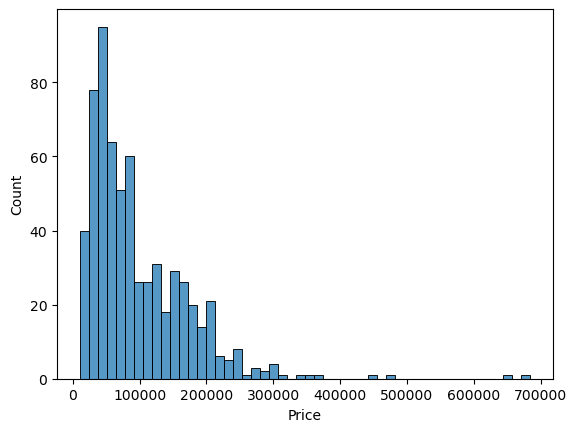

In [5]:
sns.histplot(df['Price'],bins=50)
plt.show()

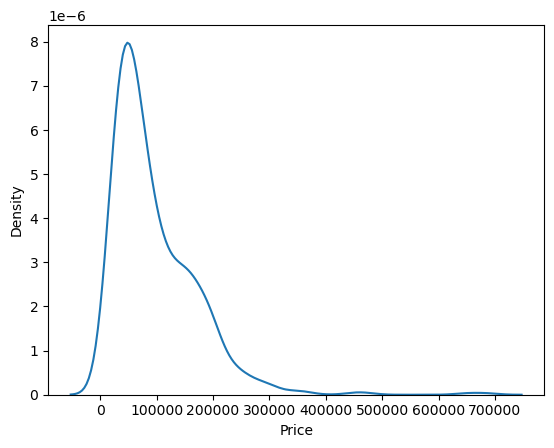

In [4]:
sns.kdeplot(df['Price'])
plt.show()


In [5]:
df['Price'].skew()

2.373787680216581

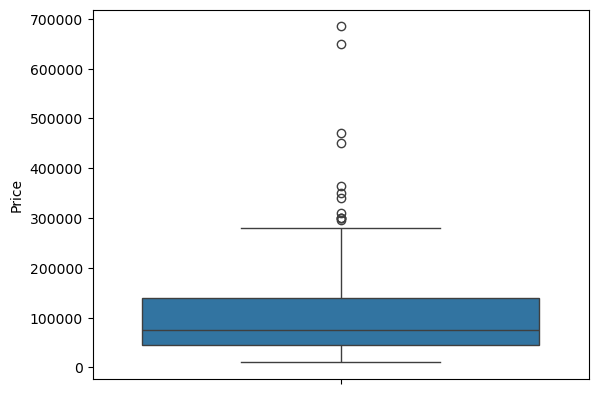

In [6]:
sns.boxplot(df['Price'])
plt.show()

In [7]:
#Examining Outliers using IQR method

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)

In [8]:
df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

Registration_year            Brand                           Model  \
59               2023         Kawasaki                       Ninja 300   
66               2019  Harley-Davidson                  Street 750 BS6   
100              2019          Benelli            TNT 600i BS4 ABS BS4   
118              2015           Ducati                 Monster 795 STD   
173              2016          Hyosung            GV650 Aquila Pro STD   
199              2018  Harley-Davidson                  Street 750 STD   
235              2015          Benelli    TNT 600i BS4 Limited Edition   
241              2022              BMW            G 310 RR Style Sport   
343              2022         Kawasaki                          Z650RS   
404              2021              BMW                        G 310 GS   
443              2021    Royal Enfield   Interceptor 650 Ravishing Red   
555              2023              BMW            G 310 RR Style Sport   

       Type   Price  Km_Driven Ownership       Location  
59   Petrol  365000       1125     First         Mumbai  
66   Petrol  350000      10000     First           Pune  
100  Petrol  470000      20000     Third          Delhi  
118  Petrol  685000      19200    Second          Delhi  
173  Petrol  295000      10000     First  Visakhapatnam  
199  Petrol  450000      15000    Second      Bangalore  
235  Petrol  340000      35000    Second     Coimbatore  
241  Petrol  310000      10000     First          Delhi  
343  Petrol  650000        800     First          Delhi  
404  Petrol  300000       5000     First       Guwahati  
443  Petrol  300000      10000     First      Bangalore  
555  Petrol  300000       1700     First        Gurgaon

In [ ]:
temp = df[df['Price'] == 850000]
df.loc[temp.index,'Price'] = np.nan

In [ ]:
splendor_mean = df[(df['Model'].str.contains("Splendor")) & (df['Ownership'] == 'First')]['Price'].mean()
df.loc[temp.index,"Price"] = int(splendor_mean)

In [ ]:
df['Price'] = df['Price'].astype('Int64')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Registration_year  636 non-null    object
 1   Brand              636 non-null    object
 2   Model              636 non-null    object
 3   Type               636 non-null    object
 4   Price              636 non-null    int64 
 5   Km_Driven          636 non-null    int64 
 6   Ownership          636 non-null    object
 7   Location           636 non-null    object
dtypes: int64(2), object(6)
memory usage: 39.9+ KB


In [6]:
#plotting the graphs again to see changes
df['Price'].describe()

count       636.000000
mean      96647.199686
std       75574.207842
min       10000.000000
25%       45000.000000
50%       75000.000000
75%      140000.000000
max      685000.000000
Name: Price, dtype: float64

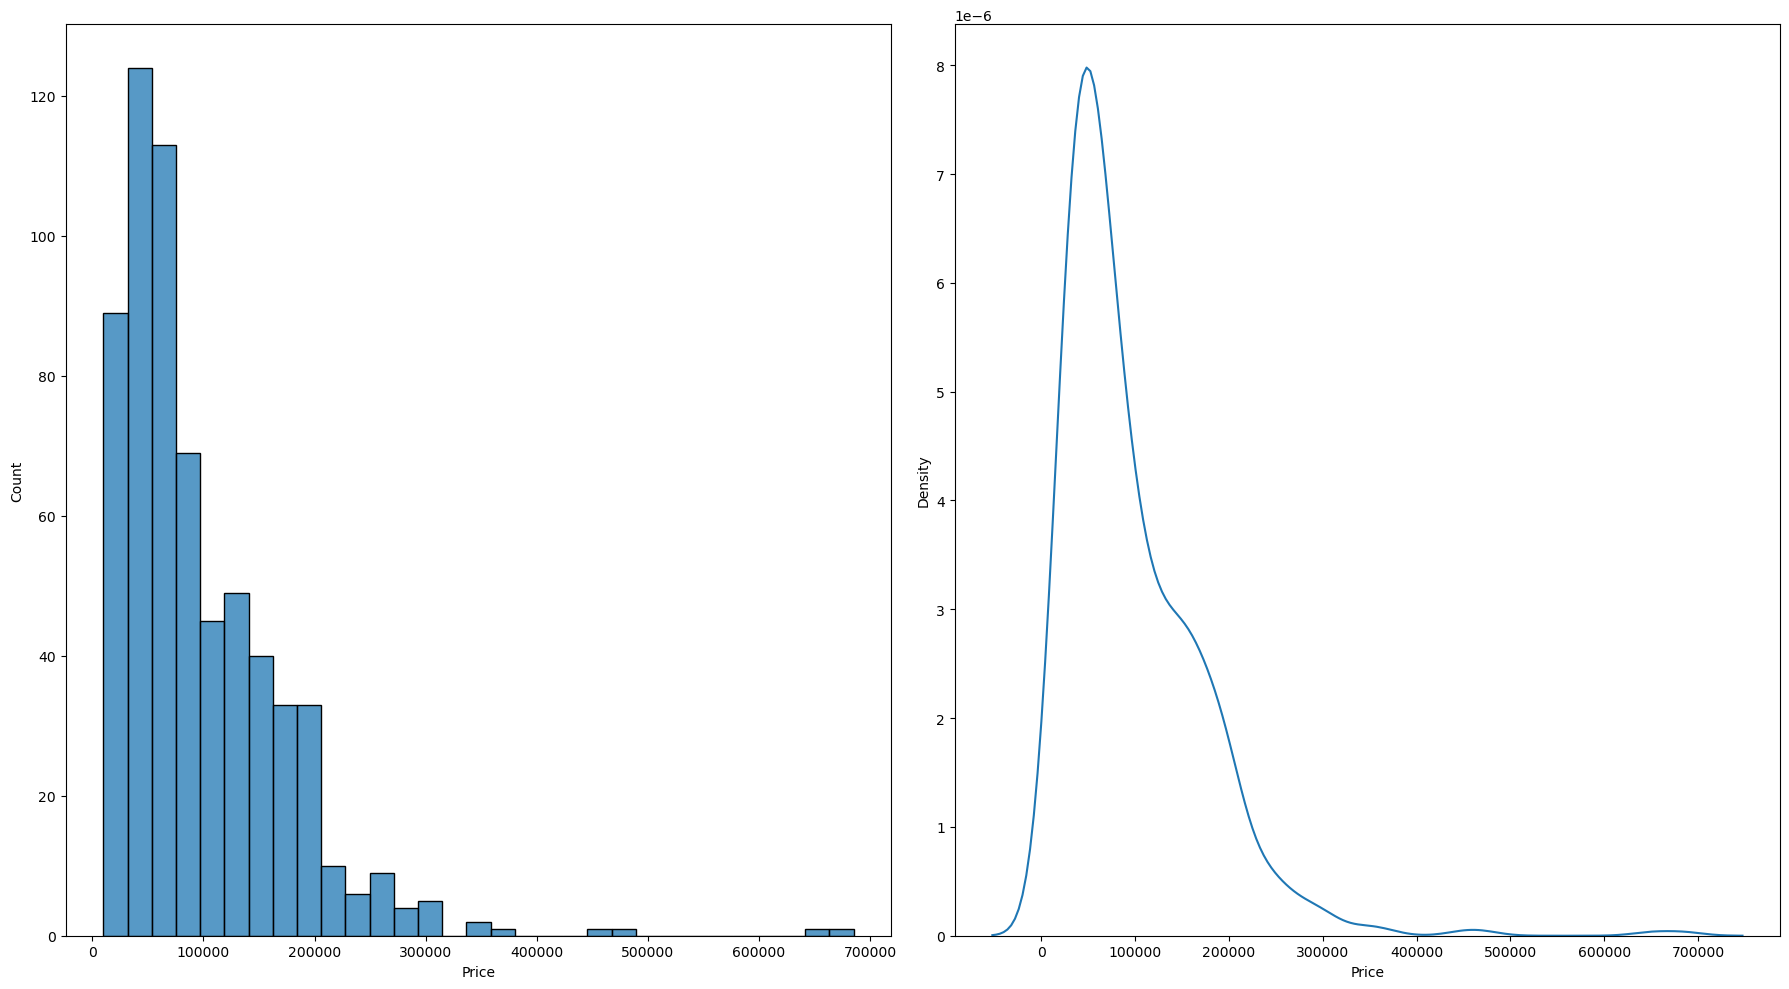

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,10))
sns.histplot(df['Price'],ax=ax[0])
sns.kdeplot(df['Price'],ax=ax[1])
plt.tight_layout()
plt.show()


### Km_Driven

 **Initial Observation**

- Range: 273 km â€“ 200,000 km
- The data is positively skewed.
- Outliers are clearly observed in the higher mileage range.

**Outlier Inspection**

- Few bikes with extremely high usage (close to 200,000 km).
- These may be genuine high-usage cases (older or commercial bikes) rather than just errors.

**Data Cleaning**

- Outliers were not removed, as data is from a real listing website and could represent actual cases.
- Keeping them ensures dataset authenticity and avoids information loss.

**Insights**

- Majority of bikes fall in the 20,000 â€“ 80,000 km range, representing typical resale mileage.
- Very high-mileage bikes (>120,000 km) are rare but indicate long-term usage or commercial use.
- Buyers likely prefer low to mid-range mileage bikes, reinforcing market demand for less-used vehicles.

In [71]:
df['Km_Driven'].describe()

count       636.000000
mean      26125.721698
std       22911.935438
min         273.000000
25%       10000.000000
50%       20000.000000
75%       35000.000000
max      200000.000000
Name: Km_Driven, dtype: float64

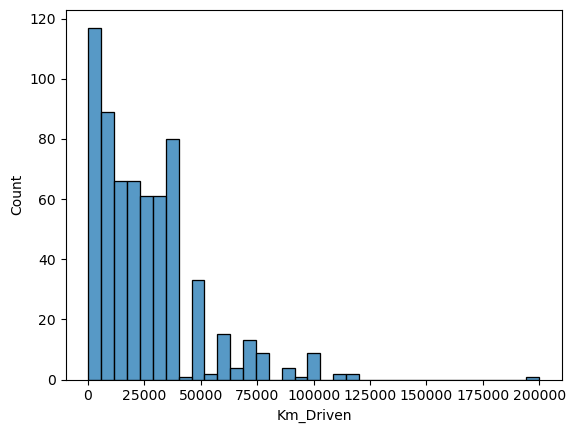

In [72]:
sns.histplot(df['Km_Driven'])
plt.show()

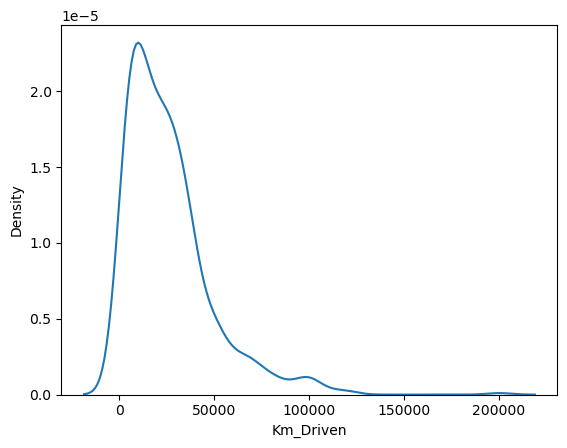

In [73]:
sns.kdeplot(df['Km_Driven'])
plt.show()

In [74]:
#Examining Outliers using IQR method

Q1 = df['Km_Driven'].quantile(0.25)
Q3 = df['Km_Driven'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)

In [75]:
outliers = df[(df['Km_Driven'] < lower_bound) | (df['Km_Driven'] > upper_bound)]

In [76]:
outliers

Registration_year          Brand  \
22               2021            KTM   
33               2014  Royal Enfield   
34               2012         Yamaha   
81               2016           Hero   
83               2023           Hero   
102              2011          Bajaj   
147              2017         Yamaha   
150              2018            TVS   
196              2011           Hero   
208              2011           Hero   
213              2011         Suzuki   
229              2011         Yamaha   
267              2014          Honda   
289              2010            TVS   
313              2012          Bajaj   
337              2012          Bajaj   
350              2011          Bajaj   
364              2016            TVS   
372              2013          Bajaj   
382              2011            TVS   
388              2020          Honda   
390              2016          Honda   
415              2014           Hero   
428              2016  Royal Enfield   
483              2010            TVS   
521              2017          Bajaj   
580              2022            TVS   
635              2013          Honda   

                                               Model    Type   Price  \
22                                      250 Duke STD  Petrol  160000   
33                             Bullet 350 ES ABS BS4  Petrol  110000   
34                         FZ S FI (V 2.0) Dual Disc  Petrol   40000   
81                                  Ignitor 125 Drum  Petrol   25000   
83                                 Splendor Plus i3s  Petrol   57285   
102                                   Discover 100 M  Petrol   20000   
147                              FZ S FI (V 2.0) STD  Petrol   35000   
150  Apache RTR 160 4V Carburetor Single Disc (2018)  Petrol   55000   
196                               Honda Splendor Pro  Petrol   30000   
208                                    Honda CD Dawn  Petrol   10000   
213        Access 125 Drum Brake CBS Special Edition  Petrol   18000   
229                                    Fazer 153 STD  Petrol   26000   
267                                   CB Trigger 150  Petrol   20000   
289                                 Apache 2007-2011  Petrol   25000   
313                                  Avenger 220 STD  Petrol   35000   
337                        Pulsar 150(2009-2014) STD  Petrol   25000   
350                                   Pulsar 150 ABS  Petrol   30000   
364                                      Jupiter STD  Petrol   25000   
372                        Pulsar 150(2009-2014) STD  Petrol   50000   
382                                             Wego  Petrol   20000   
388                                       Hornet 2.0  Petrol   80000   
390                                    Activa 3G STD  Petrol   40000   
415                                    Maestro 110cc  Petrol   20000   
428                             Himalayan Snow White  Petrol   96700   
483                                   Apache RTR 180  Petrol   18000   
521                                  Dominar 400 BS4  Petrol   88500   
580                              Apache RTR 160 Disc  Petrol  110000   
635                                   Dream Yuga 110  Petrol   30000   

     Km_Driven Ownership          Location  
22       90000    Second             Delhi  
33      120000     Above  Hubballi-Dharwad  
34       80000     First         Hyderabad  
81       90000     Third          Guwahati  
83       90000     First         Bangalore  
102     100000     First             Dhule  
147     110000     First         Hyderabad  
150     100000     First             Delhi  
196     100000     First              Pune  
208     100000    Second         Hyderabad  
213     200000     Third           Lucknow  
229      90000     First             Noida  
267      80000     First           Lucknow  
289      80000    Second            Rajkot  
313     100000     First         Bangalore  
337     100000     First          

### Registration Year

**intial_obseravtions**

- Registration_year contains the valid values of year from (2007 to 2024)
- One data validity issue a row contains "KTM" instead of year (index : 524)

**Data Cleaning**

- Replacing the value "KTM" with "2021" for row: 524, whose  registration_year 2021 was present in the "Model" column

**Insights**

- Most bikes are from 2017â€“2022, with 2021â€“22 dominating the resale market. Very few older bikes (pre-2015) are listed, showing strong demand for newer models.

In [77]:
df['Registration_year'].value_counts()

Registration_year
2021    90
2022    86
2018    66
2017    53
2016    52
2019    49
2020    47
2023    46
2015    32
2014    31
2013    25
2012    18
2011    17
2010    13
2024     4
2009     4
2007     2
KTM      1
Name: count, dtype: int64

In [78]:
df.loc[524,'Registration_year'] = '2021'

In [79]:
df['Registration_year'].value_counts()

Registration_year
2021    91
2022    86
2018    66
2017    53
2016    52
2019    49
2020    47
2023    46
2015    32
2014    31
2013    25
2012    18
2011    17
2010    13
2024     4
2009     4
2007     2
Name: count, dtype: int64

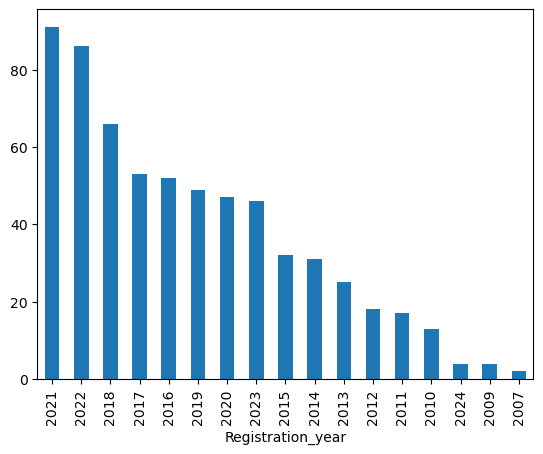

In [80]:
# plotting bar plot for Registration_year's value_counts
df['Registration_year'].value_counts().plot(kind='bar')
plt.show()

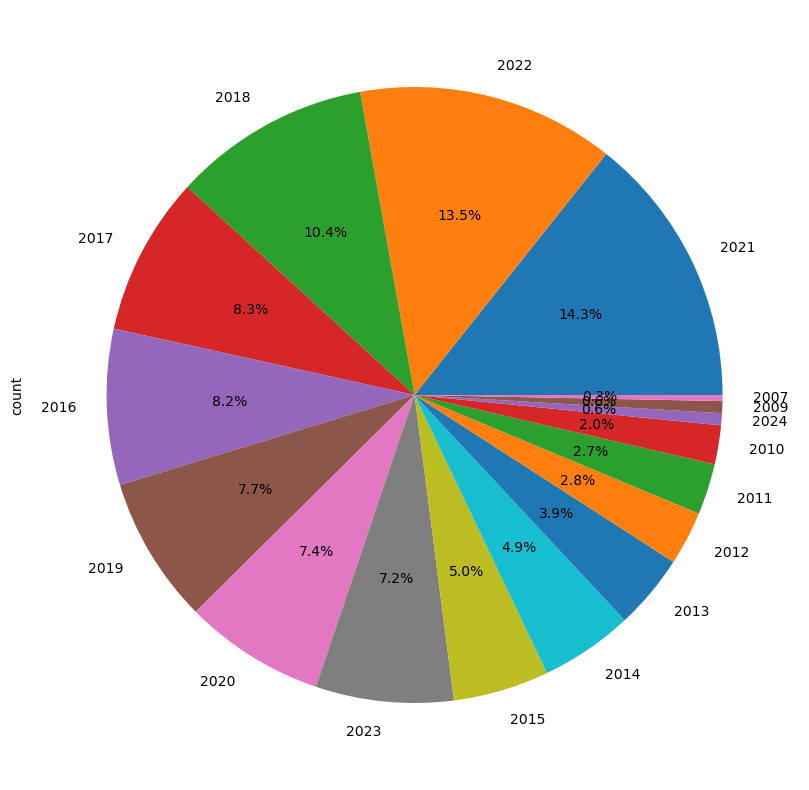

In [81]:
# plotting bar plot for Registration_year's value_counts
plt.figure(figsize=(10,10))
df['Registration_year'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()

### Ownership

**intail_observations**

- Most of the bikes are First Ownership, some are Second Ownership, and only 16 bikes are Third Ownership & 5 bikes are Fourth+ Ownership(Above)

In [17]:
df['Ownership'].value_counts()

Ownership
First     529
Second     86
Third      16
Above       5
Name: count, dtype: int64

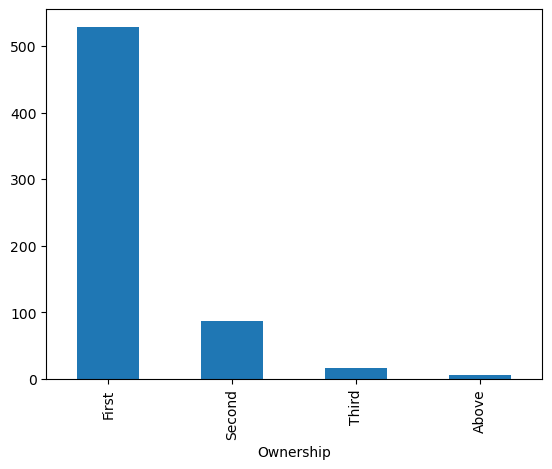

In [18]:
df['Ownership'].value_counts().plot(kind="bar")
plt.show()

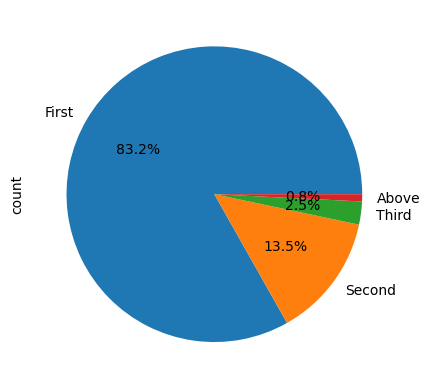

In [19]:
df['Ownership'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()

### Brand 

**intail_observations**

- The dataset is dominated by Bajaj (106 bikes), Honda (100), and Royal Enfield (92), which together make up a large share of the listings.
- Mid-range presence includes TVS (70), Hero (64), Yamaha (52), and Suzuki (35).
- Premium and niche brands such as KTM (25), Jawa (17), and Yezdi (12) also appear with moderate frequency.
- Several international and electric brands like BMW, Harley-Davidson, Ducati, Revolt, Ola, Okinawa, etc. are present, but with very few entries (1â€“4 each).
- Overall, the dataset is skewed toward mass-market Indian brands, with only a handful of listings for luxury or electric two-wheelers.

In [20]:
df['Brand'].value_counts()

Brand
Bajaj              106
Honda              100
Royal Enfield       92
TVS                 70
Hero                64
Yamaha              52
Suzuki              35
KTM                 25
Jawa                17
Yezdi               12
Vespa               11
Aprilia              7
Revolt               6
Benelli              4
Hyosung              4
Mahindra             4
Kawasaki             3
BMW                  3
Husqvarna            2
Ola                  2
Harley-Davidson      2
UM                   2
PURE                 2
Triumph              2
Odysse               1
Benling              1
Ducati               1
BGauss               1
Okaya                1
Okinawa              1
Tunwal               1
Komaki               1
Ampere               1
Name: count, dtype: int64

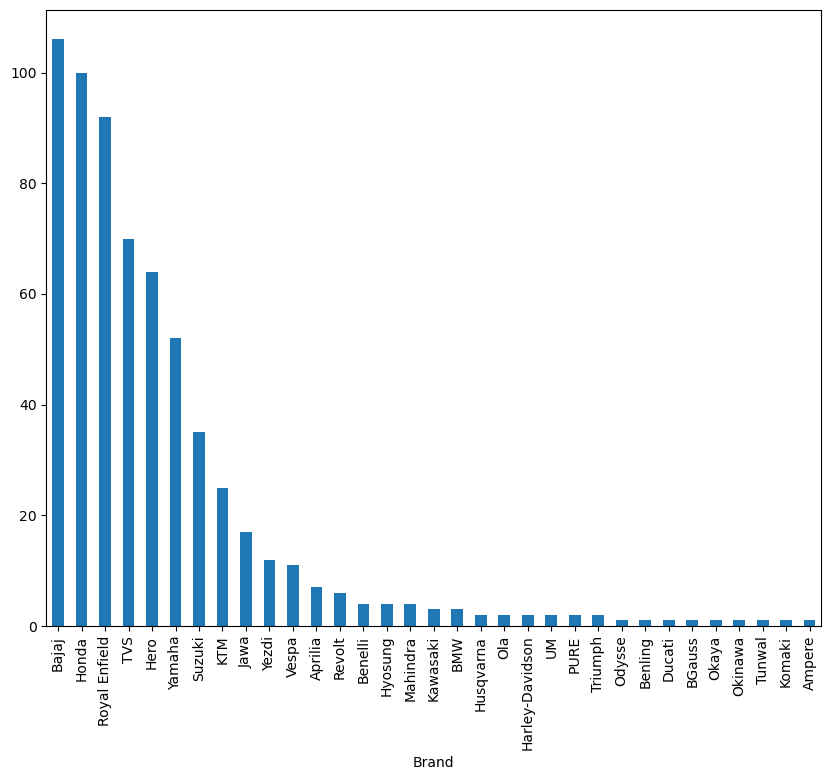

In [21]:
plt.figure(figsize=(10,8))
df['Brand'].value_counts().plot(kind="bar")
plt.show()

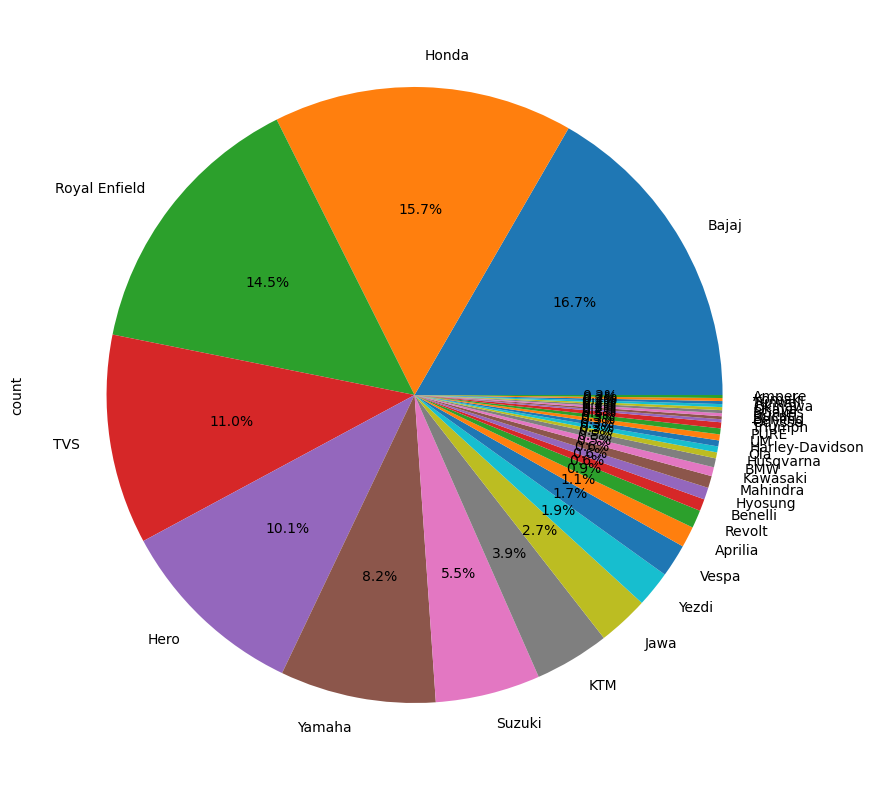

In [22]:
plt.figure(figsize=(18,10))
df['Brand'].value_counts().plot(kind="pie",autopct="%1.1f%%")
plt.show()

### Location

**intail_observations**

- Majority of bikes are from the cities Mumbai, Bangalore, Mumbai, Pune, Hyderabad and Kolkata
- These top 5 cities together account for a large share of the listings.
- A moderate number of listings are from cities like Kolkata (34), Noida (24), Chennai (19), Gurgaon (18), and Ghaziabad (18).
- Many other cities have only a handful of listings (1â€“5 bikes), indicating a long tail distribution.
- This suggests that the dataset is city-heavy towards metro/tier-1 locations, while tier-2 and tier-3 cities are underrepresented.

In [23]:
df['Location'].value_counts()

Location
Delhi        119
Bangalore     61
Mumbai        56
Pune          42
Hyderabad     40
            ... 
Srinagar       1
Jalandhar      1
Motihari       1
Budaun         1
Vidisha        1
Name: count, Length: 101, dtype: int64

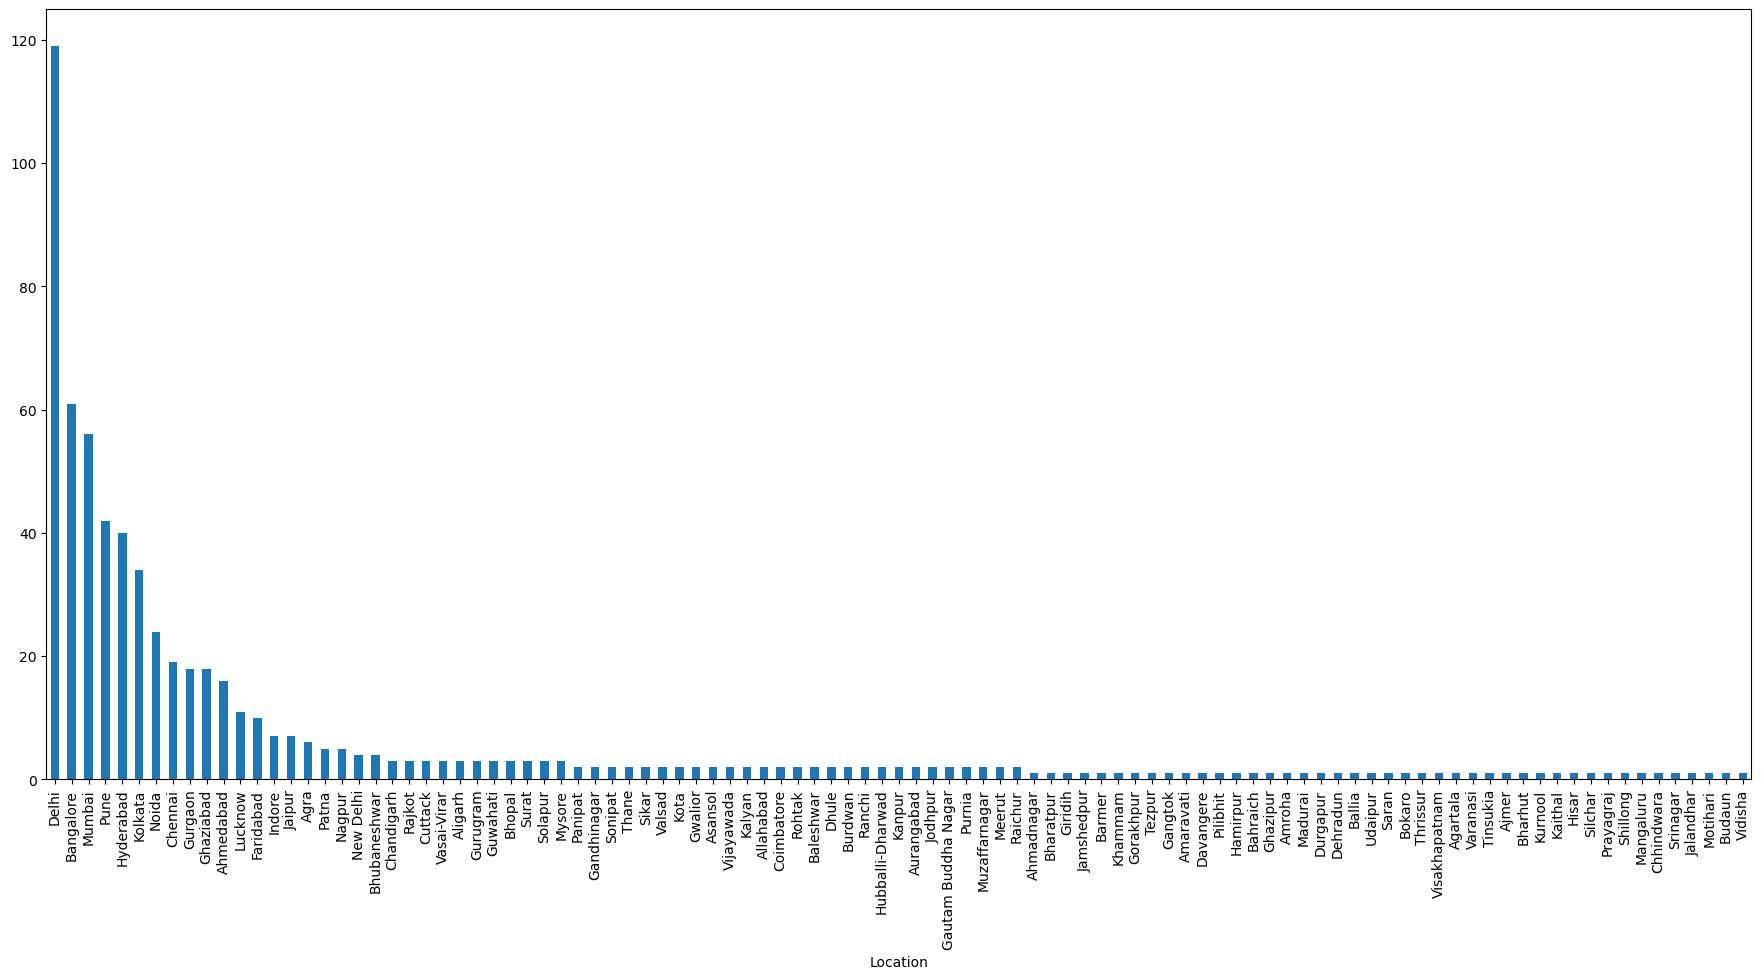

In [24]:
plt.figure(figsize=(22,10))
df['Location'].value_counts().plot(kind='bar')
plt.show()

### Type

**intail_observations**

- The dataset is heavily dominated by Petrol bikes (628 bikes, ~99%).
- Only 8 bikes (~1%) are EV (Electric Vehicles).
- This suggests that the market/data collected is still largely petrol-oriented, with EV adoption being minimal.

In [25]:
df['Type'].value_counts()

Type
Petrol    628
EV          8
Name: count, dtype: int64

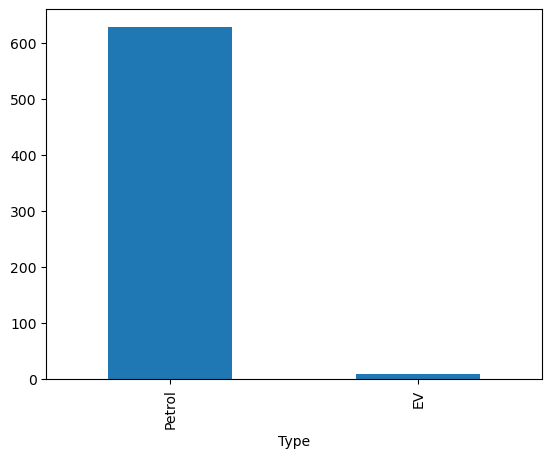

In [26]:
df['Type'].value_counts().plot(kind='bar')
plt.show()

## Bivariate Analysis

Analyzing the relationship between two columns (variables) at a time.

**Types**:

- Numerical - Numerical
- Numerical - Categorical
- Categorical - Categorical

### 1. Categorical - Categorical


#### Regestration_year - Type

#### Insights

- Petrol bikes dominate registrations across all years in the dataset.
- EV bikes started appearing only from 2021, with very small numbers compared to petrol.
- There is a noticeable increase in EV registrations between 2021â€“2023, though the counts remain low.
- Petrol bike registrations show fluctuations, with a peak around 2021 and then a decline.
- The dataset highlights the early adoption stage of EV bikes, while petrol bikes remain the mainstream choice.

In [27]:
df.head()

Registration_year          Brand  \
0              2022           Hero   
1              2017          Bajaj   
2              2017          Bajaj   
3              2017          Bajaj   
4              2017  Royal Enfield   

                                              Model    Type   Price  \
0                        Passion Pro i3s Disc Alloy  Petrol   55000   
1                                  Pulsar NS160 STD  Petrol   40000   
2                              Pulsar NS200 STD BS4  Petrol   55000   
3                       Dominar 400 (2016-2018) ABS  Petrol  110000   
4   Classic 350 Redditch Series With Single-Channel  Petrol  145000   

   Km_Driven Ownership   Location  
0      30000     First  Bangalore  
1      27500     Third      Delhi  
2      66850     First  Hyderabad  
3      35000     First    Jodhpur  
4      50000     First  Bangalore

In [29]:
temp_df = pd.crosstab(index=df['Type'],columns=df['Registration_year'])
temp_df

Registration_year  2007  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
Type                                                                            
EV                    0     0     0     0     0     0     0     0     0     0   
Petrol                2     4    13    17    18    25    31    32    52    53   

Registration_year  2018  2019  2020  2021  2022  2023  2024  KTM  
Type                                                              
EV                    0     0     0     2     3     3     0    0  
Petrol               66    49    47    88    83    43     4    1

<Figure size 1200x900 with 0 Axes>

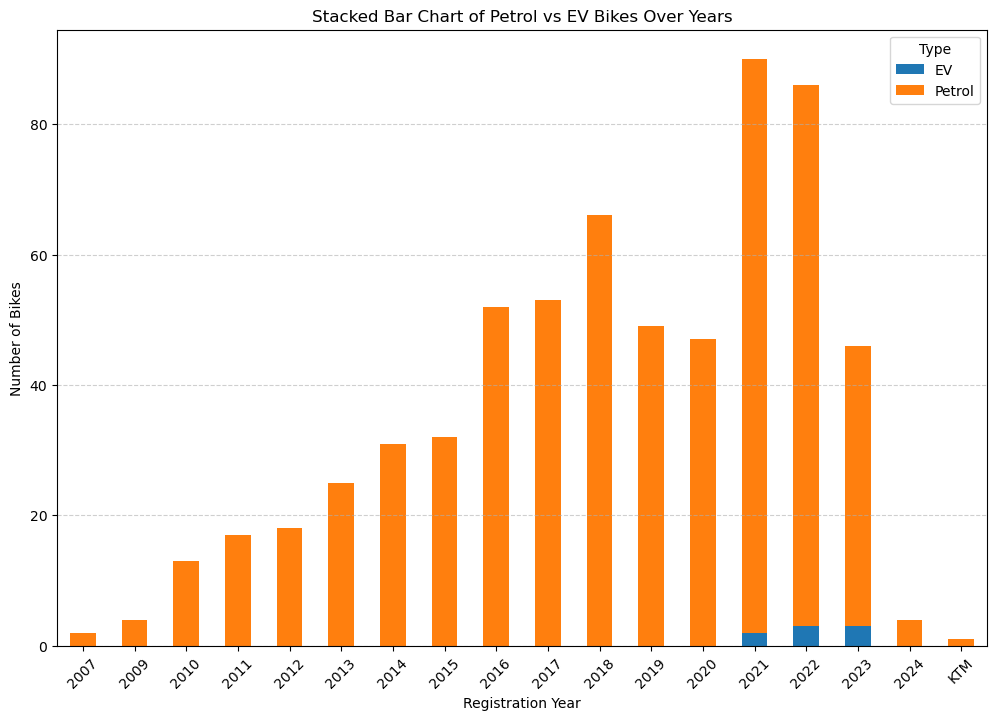

In [30]:
# Transpose so years are rows
df_plot = temp_df.T  

# Plot stacked bar chart
df_plot.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12, 8)
)

plt.xlabel("Registration Year")
plt.ylabel("Number of Bikes")
plt.title("Stacked Bar Chart of Petrol vs EV Bikes Over Years")
plt.legend(title="Type")
plt.xticks(rotation=45)  # rotate years for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Registration_year - Brand

#### Insights

**Brand-wise Yearly Registration Distribution (%)**
(How each brandâ€™s registrations are spread across years)

- Established brands like Hero, Honda, Bajaj, and TVS show consistent presence across multiple years, indicating long-term dominance and market stability.
- New-age EV brands like Ola, Ather, and Revolt appear only in recent years (2020 onwards), reflecting the industryâ€™s late shift toward electric mobility.
- Some premium/niche brands (e.g., Harley-Davidson, Triumph, BMW) have sporadic and low distribution, showing they target limited customer segments rather than mass adoption.

**Year-wise Brand Dominance (%)**
(Which brands dominated within each year)

- Honda, Hero, and Bajaj dominated the market share between 2010â€“2016, contributing the largest proportion of registrations in those years.
- From 2017 onwards, the market became more fragmented, with multiple brands sharing registrations instead of just a few leaders.
- In 2021â€“2023, EV brands (Ola, Ather, Revolt) rapidly gained share, showing a clear shift in dominance from petrol to electric segment.


In [ ]:
ct = pd.crosstab(index=df['Brand'],columns=df['Registration_year'],normalize='index')*100
bt = pd.crosstab(index=df['Brand'],columns=df['Registration_year'],normalize='columns')*100
bt = bt.round(2)
ct = ct.round(2)


In [ ]:
plt.figure(figsize=(19,10))
sns.heatmap(ct,annot=True,cmap='coolwarm',fmt='1.1f')
plt.title("Brand-wise Yearly Registration Distribution (%)", fontsize=16)
plt.xlabel("Registration Year")
plt.ylabel("Brand")
plt.show()

In [ ]:
plt.figure(figsize=(19,10))
sns.heatmap(bt,annot=True,cmap='coolwarm',fmt='1.1f')
plt.title("Year-wise Brand Dominance (%)", fontsize=16)
plt.xlabel("Registration Year")
plt.ylabel("Brand")
plt.show()

### Registration_year - Ownership

#### Insights


- First ownership dominates registrations across all years, especially after 2017, where more than 80â€“90% of bikes are from first owners.
- Second ownership shows presence mainly in older registrations (2010â€“2016) but becomes very small in recent years.
- Third & Above ownership is almost negligible, contributing very little across all years, showing that very few bikes circulate beyond the second resale.
- The overall count of bikes increases sharply after 2015, peaking around 2021â€“2022, showing higher market activity in recent years.
- First ownership segment grows significantly in recent years, dominating most of the stacked bars (2020â€“2023).
- Second ownership has a noticeable share in mid-years (2012â€“2016) but almost disappears after 2020, while third & above ownership remains very small across all years.

In [34]:
ct = pd.crosstab(index=df['Ownership'],columns=df['Registration_year'],normalize='columns')*100
ct = ct.round(2)

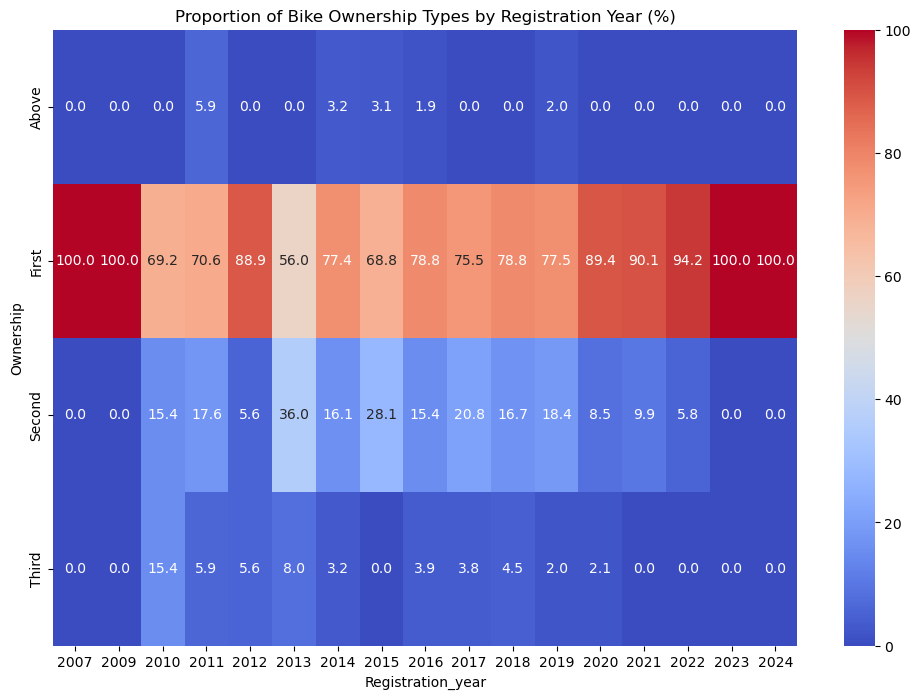

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(ct,annot=True,cmap='coolwarm',fmt='1.1f')
plt.title("Proportion of Bike Ownership Types by Registration Year (%)")
plt.show()

In [36]:
ct = pd.crosstab(index=df['Ownership'],columns=df['Registration_year'])
ct = ct.T


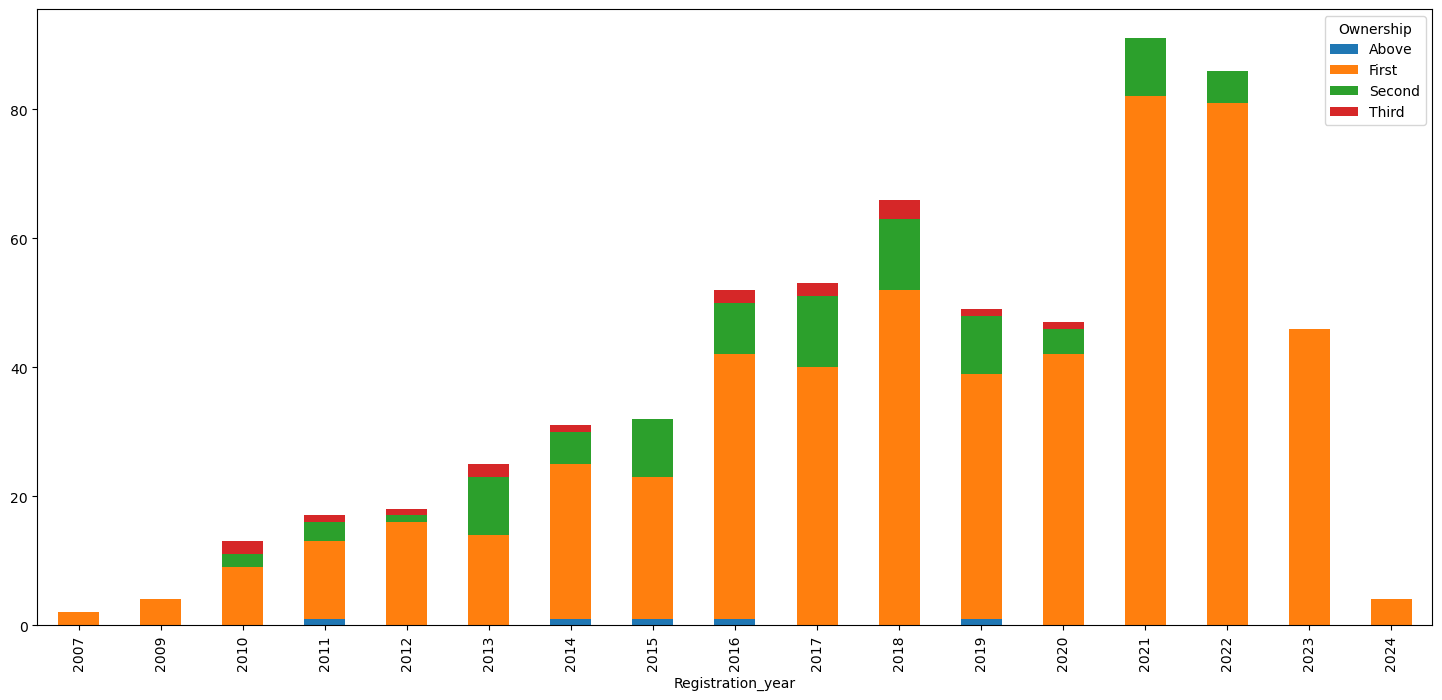

In [37]:
ct.plot(kind='bar',stacked=True,figsize=(18,8))
plt.show()

### Registration_year - Location

#### Insights

**City-level dominance :** Few cities like Delhi, Mumbai, Bangalore, Pune, and Hyderabad contribute disproportionately high shares across multiple registration years, showing these are the biggest hubs for resale of bikes.

**Regional skew :** Many smaller cities have negligible or 0% share across years, meaning the resale bike market is highly concentrated in metros and large urban centers rather than evenly spread.


In [33]:
ct = pd.crosstab(index=df['Location'],columns=df['Registration_year'],normalize='columns')*100
ct = ct.round(2)
ct

Registration_year    2007  2009   2010   2011   2012  2013   2014   2015  \
Location                                                                   
Agartala              0.0   0.0   0.00   0.00   0.00   4.0   0.00   0.00   
Agra                  0.0   0.0   0.00   5.88   0.00   0.0   3.23   0.00   
Ahmadnagar            0.0   0.0   0.00   0.00   0.00   4.0   0.00   0.00   
Ahmedabad             0.0   0.0   0.00   0.00   0.00   0.0   0.00   3.12   
Ajmer                 0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Aligarh               0.0  25.0   0.00   0.00   0.00   4.0   0.00   0.00   
Allahabad             0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Amaravati             0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Amroha                0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Asansol               0.0   0.0   0.00   0.00   0.00   0.0   3.23   0.00   
Aurangabad            0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Bahraich              0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Baleshwar             0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Ballia                0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Bangalore             0.0  25.0   0.00   0.00  16.67  12.0   9.68   9.38   
Barmer                0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Bharatpur             0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Bharhut               0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Bhopal                0.0   0.0   0.00   0.00   0.00   8.0   0.00   0.00   
Bhubaneshwar          0.0   0.0   0.00   0.00   5.56   0.0   0.00   0.00   
Bokaro                0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Budaun                0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Burdwan               0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Chandigarh            0.0   0.0   0.00   0.00   0.00   4.0   0.00   0.00   
Chennai               0.0   0.0   7.69   5.88   5.56   4.0   0.00   3.12   
Chhindwara            0.0   0.0   7.69   0.00   0.00   0.0   0.00   0.00   
Coimbatore            0.0   0.0   0.00   0.00   0.00   0.0   0.00   3.12   
Cuttack               0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Davangere             0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Dehradun              0.0   0.0   0.00   5.88   0.00   0.0   0.00   0.00   
Delhi                 0.0   0.0   7.69  23.53  16.67  16.0  29.03  12.50   
Dhule                 0.0   0.0   0.00   5.88   0.00   0.0   0.00   0.00   
Durgapur              0.0   0.0   0.00   0.00   5.56   0.0   0.00   0.00   
Faridabad             0.0   0.0   0.00   5.88   0.00   0.0   0.00   0.00   
Gandhinagar           0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Gangtok               0.0   0.0   0.00   0.00   0.00   0.0   0.00   3.12   
Gautam Buddha Nagar   0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Ghaziabad             0.0   0.0   7.69   0.00   5.56   4.0   6.45   0.00   
Ghazipur              0.0   0.0   0.00   0.00   0.00   0.0   3.23   0.00   
Giridih               0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Gorakhpur             0.0  25.0   0.00   0.00   0.00   0.0   0.00   0.00   
Gurgaon               0.0   0.0   0.00   0.00   0.00   4.0   3.23   6.25   
Gurugram              0.0   0.0   0.00   0.00   0.00   0.0   0.00   3.12   
Guwahati              0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Gwalior               0.0   0.0   0.00   0.00   0.00   0.0   0.00   3.12   
Hamirpur              0.0   0.0   0.00   0.00   0.00   4.0   0.00   0.00   
Hisar                 0.0   0.0   0.00   0.00   0.00   0.0   0.00   0.00   
Hubballi-Dharwad      0.0   0.0   0.00   0.00   0.00   0.0   3.23   0.00   
Hyderabad             0.0   0.0   7.69   5.88   5.56   4.0   0.00   3.12   
Indore                0.0   0.0   7.69   5.88   0.00   0.0   0.00   0.00   
Jaipur                0.0   0.0   0.00   0.00  1

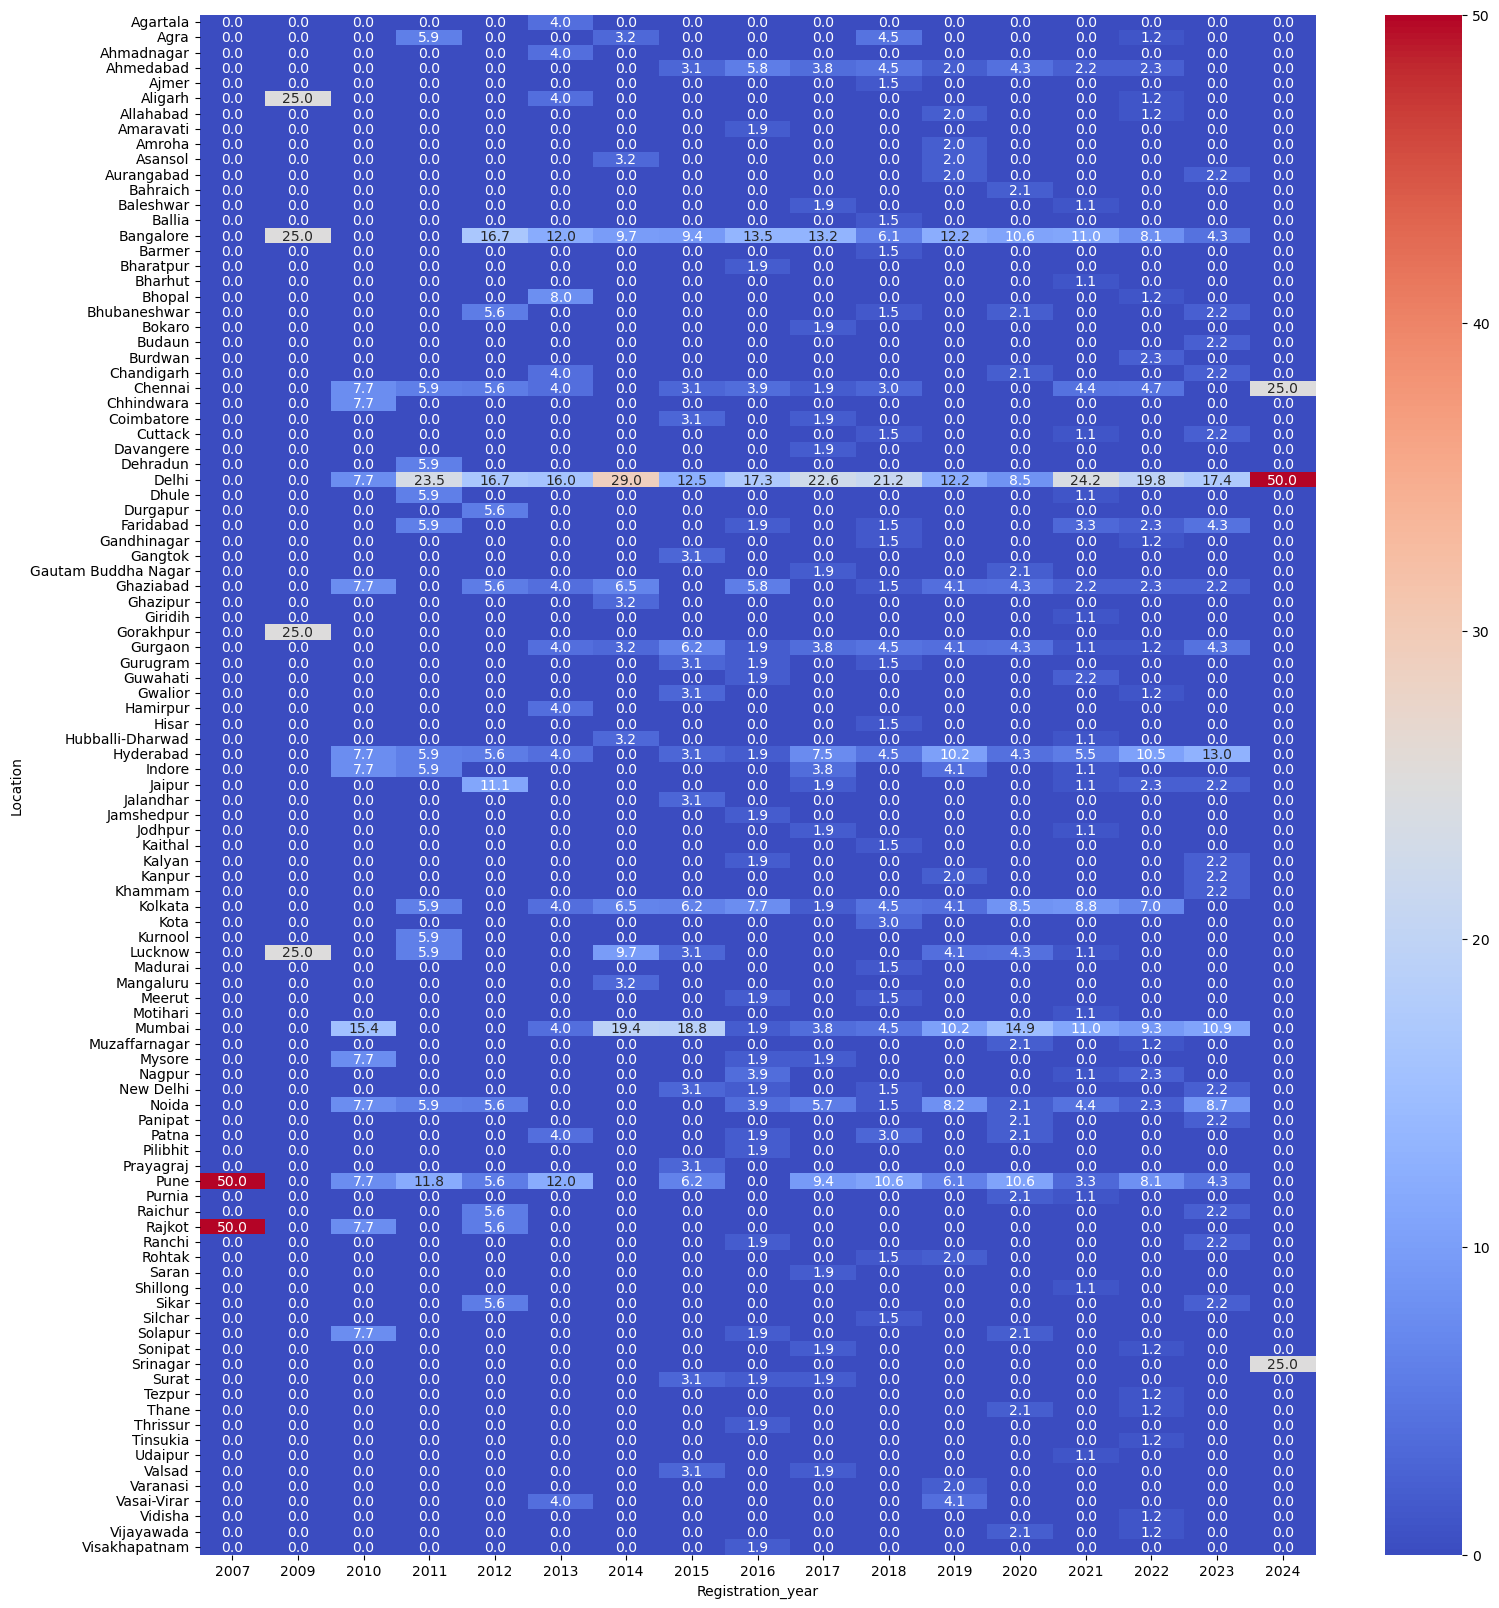

In [39]:
plt.figure(figsize=(18,20))
sns.heatmap(ct,cmap="coolwarm",fmt='1.1f',annot=True)
plt.show()

### Brand - Ownership

#### Insights 

**Mainstream brands dominate early ownership (First & Second) :** Honda, Bajaj, Hero, TVS, Royal Enfield, and Yamaha together account for the bulk of first and second-owner bikes, showing they drive the resale market.

**Luxury & niche brands show up mostly in later ownerships (Above/Third) :** Brands like KTM, Royal Enfield, Vespa, Yamaha have notable shares in third and above ownerships, suggesting enthusiasts keep reselling/upgrading within these segments, unlike premium brands (BMW, Ducati) that rarely move beyond first resale.

In [34]:
ct = pd.crosstab(index=df['Brand'],columns=df['Ownership'],normalize='columns')
ct

Ownership        Above     First    Second   Third
Brand                                             
Ampere             0.0  0.001890  0.000000  0.0000
Aprilia            0.0  0.005671  0.046512  0.0000
BGauss             0.0  0.001890  0.000000  0.0000
BMW                0.0  0.005671  0.000000  0.0000
Bajaj              0.2  0.172023  0.139535  0.1250
Benelli            0.0  0.001890  0.011628  0.1250
Benling            0.0  0.001890  0.000000  0.0000
Ducati             0.0  0.000000  0.011628  0.0000
Harley-Davidson    0.0  0.001890  0.011628  0.0000
Hero               0.0  0.098299  0.127907  0.0625
Honda              0.0  0.151229  0.197674  0.1875
Husqvarna          0.0  0.003781  0.000000  0.0000
Hyosung            0.0  0.001890  0.034884  0.0000
Jawa               0.0  0.032136  0.000000  0.0000
KTM                0.2  0.034026  0.069767  0.0000
Kawasaki           0.0  0.003781  0.011628  0.0000
Komaki             0.0  0.001890  0.000000  0.0000
Mahindra           0.0  0.005671  0.011628  0.0000
Odysse             0.0  0.001890  0.000000  0.0000
Okaya              0.0  0.001890  0.000000  0.0000
Okinawa            0.0  0.001890  0.000000  0.0000
Ola                0.0  0.003781  0.000000  0.0000
PURE               0.0  0.003781  0.000000  0.0000
Revolt             0.0  0.011342  0.000000  0.0000
Royal Enfield      0.2  0.155009  0.069767  0.1875
Suzuki             0.0  0.052930  0.069767  0.0625
TVS                0.0  0.111531  0.081395  0.2500
Triumph            0.0  0.001890  0.011628  0.0000
Tunwal             0.0  0.001890  0.000000  0.0000
UM                 0.0  0.001890  0.011628  0.0000
Vespa              0.2  0.017013  0.011628  0.0000
Yamaha             0.2  0.086957  0.058140  0.0000
Yezdi              0.0  0.020794  0.011628  0.0000

<Figure size 1200x900 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

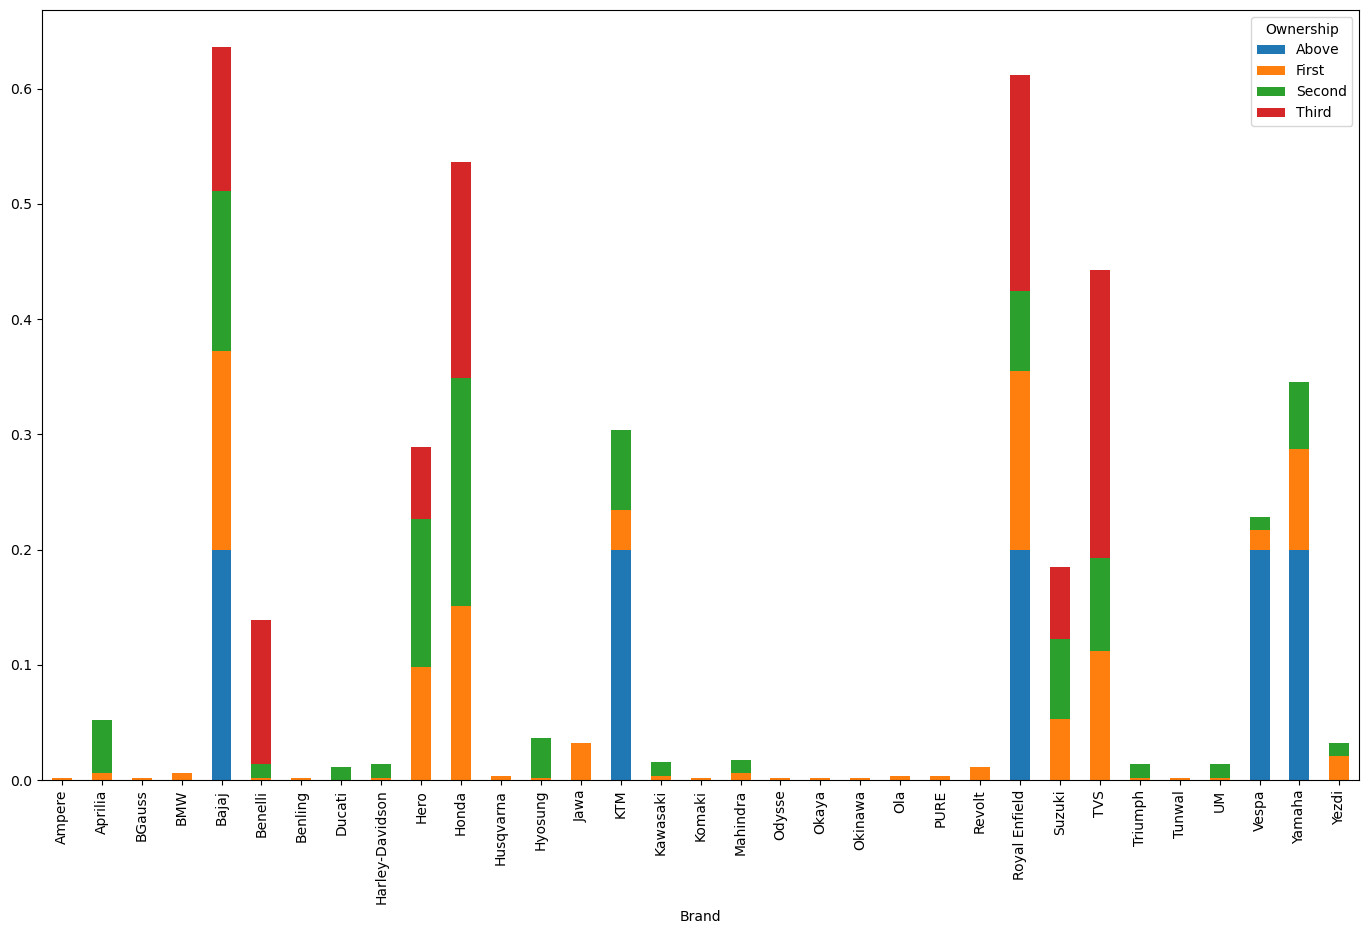

In [32]:
ct.plot(kind='bar',stacked=True,figsize=(17,10))
plt.show()

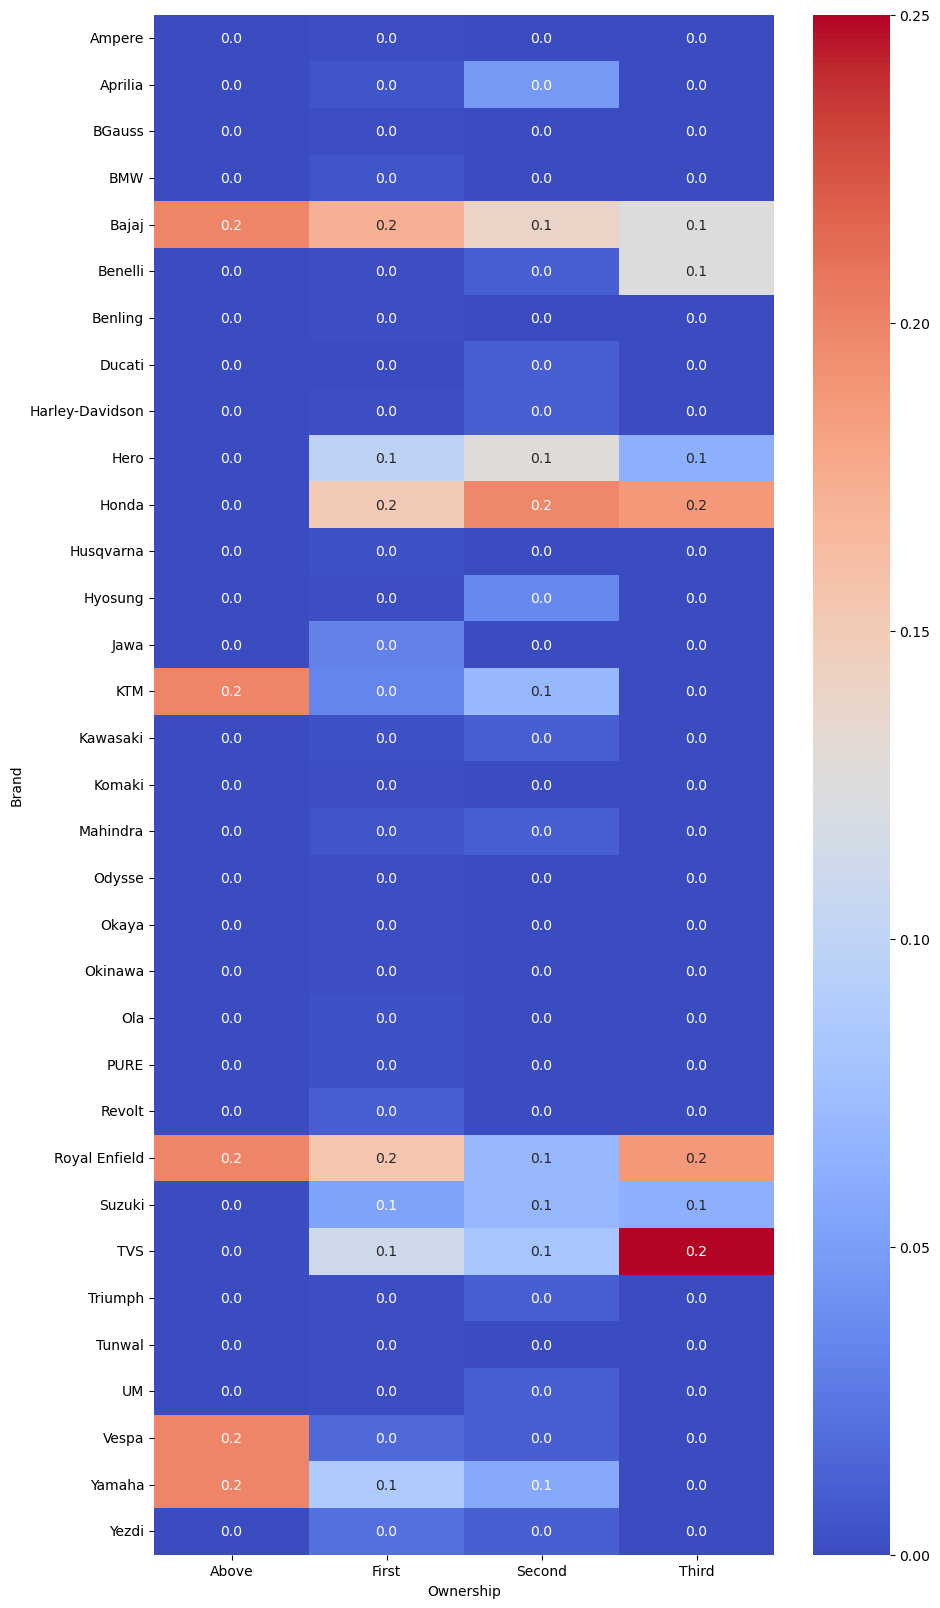

In [33]:
plt.figure(figsize=(10,20))
sns.heatmap(ct,cmap='coolwarm',annot=True,fmt='1.1f')
plt.show()

### Brand - Location

#### Insights

**Major urban hubs dominate listings :** Cities like Delhi, Bangalore, Mumbai, Hyderabad, Pune, Noida, Kolkata, Ghaziabad have the highest concentration of multiple brands â€” showing that metro and tier-1 cities drive the bulk of the used bike market.

**Brand diversity is highest in metros :** In places like Delhi, Mumbai, Bangalore, Hyderabad, and Pune, you see a wide variety of brands (from Honda, Bajaj, Royal Enfield to premium brands like BMW, Aprilia, Triumph). In contrast, smaller towns usually show only one or two mainstream brands (Hero, Bajaj, Honda).

In [36]:
ct = pd.crosstab(index=df['Location'],columns=df['Brand'])
ct

Brand                Ampere  Aprilia  BGauss  BMW  Bajaj  Benelli  Benling  \
Location                                                                     
Agartala                  0        0       0    0      0        0        0   
Agra                      0        0       0    0      1        0        0   
Ahmadnagar                0        0       0    0      0        0        0   
Ahmedabad                 0        0       0    0      3        0        0   
Ajmer                     0        0       0    0      0        0        0   
Aligarh                   0        0       0    0      2        0        0   
Allahabad                 0        0       0    0      1        0        0   
Amaravati                 0        0       0    0      0        0        0   
Amroha                    0        0       0    0      0        0        0   
Asansol                   0        0       0    0      1        0        0   
Aurangabad                0        0       0    0      0        0        0   
Bahraich                  0        0       0    0      0        0        0   
Baleshwar                 0        0       0    0      0        0        0   
Ballia                    0        0       0    0      0        0        0   
Bangalore                 0        1       0    0     10        1        0   
Barmer                    0        0       0    0      0        0        0   
Bharatpur                 0        0       0    0      1        0        0   
Bharhut                   0        0       0    0      0        0        0   
Bhopal                    0        0       0    0      2        0        0   
Bhubaneshwar              0        0       0    0      0        0        0   
Bokaro                    0        0       0    0      1        0        0   
Budaun                    0        0       0    0      1        0        0   
Burdwan                   0        0       0    0      0        0        0   
Chandigarh                0        0       0    0      1        0        0   
Chennai                   0        0       1    0      4        0        0   
Chhindwara                0        0       0    0      0        0        0   
Coimbatore                0        0       0    0      0        1        0   
Cuttack                   0        0       0    0      1        0        0   
Davangere                 0        0       0    0      0        0        0   
Dehradun                  0        0       0    0      0        0        0   
Delhi                     0        1       0    1     22        1        1   
Dhule                     0        0       0    0      1        0        0   
Durgapur                  0        0       0    0      0        0        0   
Faridabad                 0        0       0    0      0        0        0   
Gandhinagar               0        0       0    0      0        0        0   
Gangtok                   0        0       0    0      0        0        0   
Gautam Buddha Nagar       0        0       0    0      0        0        0   
Ghaziabad                 0        0       0    0      2        0        0   
Ghazipur                  0        0       0    0      0        0        0   
Giridih                   0        0       0    0      1        0        0   
Gorakhpur                 0        0       0    0      0        0        0   
Gurgaon                   0        0       0    1      1        0        0   
Gurugram                  0        0       0    0      0        0        0   
Guwahati                  0        0       0    1      0        0        0   
Gwalior                   0        0       0    0      1        0        0   
Hamirpur                  0        0       0    0      1        0        0   
Hisar                     0        0       0    0      1        0        0   
Hubballi-Dharwad          0        0       0    0      0        0        0   
Hyderabad                 0        1       0    0      5        0        0   
Indore                

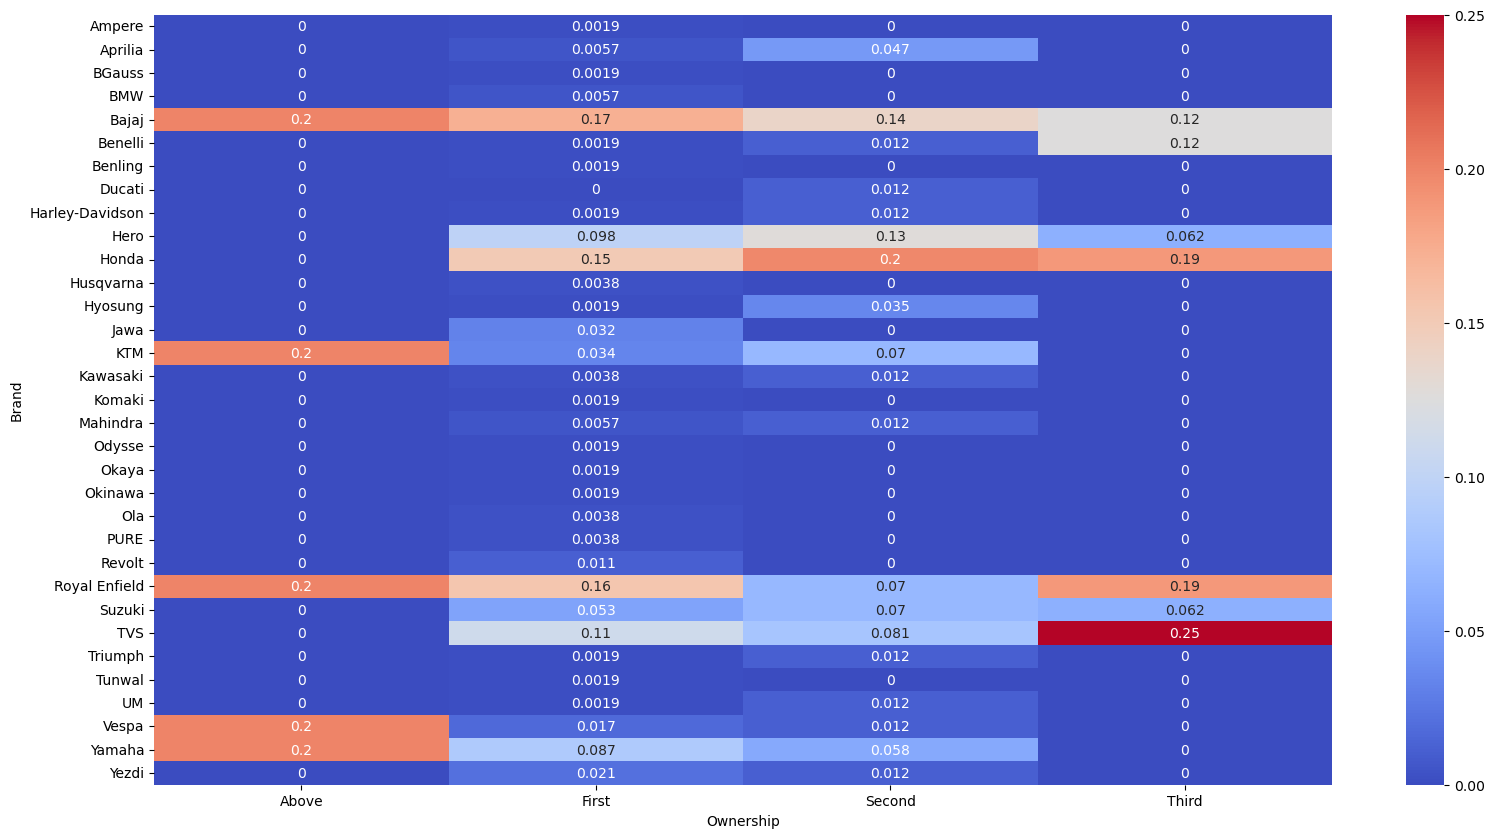

In [35]:
plt.figure(figsize=(19,10))
sns.heatmap(ct,cmap='coolwarm',annot=True)
plt.show()

### Ownership - Location

#### Insights

**Metro cities dominate first-ownership bikes :** Delhi (100), Bangalore (48), Mumbai (46), Hyderabad (35), Pune (34), Kolkata (29), and Noida (22) have the highest concentration of first-owner bikes, showing that major metros are the biggest contributors to the used bike market.

**Second-ownership bikes are scattered but much smaller in number :** Only a few cities (Bangalore â€“ 13, Delhi â€“ 16, Mumbai â€“ 7, Pune â€“ 7, Chennai â€“ 4) show noticeable second-owner bike presence, while in most other locations, bikes are overwhelmingly first-owner.

In [39]:
ct = pd.crosstab(index=df['Location'],columns=df['Ownership'])
ct

Ownership            Above  First  Second  Third
Location                                        
Agartala                 0      1       0      0
Agra                     0      6       0      0
Ahmadnagar               0      0       1      0
Ahmedabad                0     16       0      0
Ajmer                    0      0       1      0
Aligarh                  0      2       1      0
Allahabad                0      2       0      0
Amaravati                1      0       0      0
Amroha                   0      1       0      0
Asansol                  0      2       0      0
Aurangabad               0      2       0      0
Bahraich                 0      1       0      0
Baleshwar                0      2       0      0
Ballia                   0      1       0      0
Bangalore                0     48      13      0
Barmer                   0      1       0      0
Bharatpur                0      1       0      0
Bharhut                  0      1       0      0
Bhopal                   0      2       1      0
Bhubaneshwar             0      4       0      0
Bokaro                   0      0       1      0
Budaun                   0      1       0      0
Burdwan                  0      2       0      0
Chandigarh               0      3       0      0
Chennai                  0     14       4      1
Chhindwara               0      1       0      0
Coimbatore               0      1       1      0
Cuttack                  0      3       0      0
Davangere                0      1       0      0
Dehradun                 0      1       0      0
Delhi                    0    100      16      3
Dhule                    0      1       1      0
Durgapur                 0      0       0      1
Faridabad                0      9       1      0
Gandhinagar              0      2       0      0
Gangtok                  0      0       1      0
Gautam Buddha Nagar      0      1       0      1
Ghaziabad                0     17       0      1
Ghazipur                 0      1       0      0
Giridih                  0      1       0      0
Gorakhpur                0      1       0      0
Gurgaon                  0     14       4      0
Gurugram                 0      1       1      1
Guwahati                 0      2       0      1
Gwalior                  0      2       0      0
Hamirpur                 0      1       0      0
Hisar                    0      0       0      1
Hubballi-Dharwad         1      1       0      0
Hyderabad                0     35       5      0
Indore                   1      3       3      0
Jaipur                   0      6       1      0
Jalandhar                0      1       0      0
Jamshedpur               0      0       1      0
Jodhpur                  0      2       0      0
Kaithal                  0      1       0      0
Kalyan                   0      2       0      0
Kanpur                   0      2       0      0
Khammam                  0      1       0      0
Kolkata                  0     29       4      1
Kota                     0      1       1      0
Kurnool                  0      0       1      0
Lucknow                  1      9       0      1
Madurai                  0      1       0      0
Mangaluru                0      1       0      0
Meerut                   0      2       0      0
Motihari                 0      1       0      0
Mumbai                   1     46       7      2
Muzaffarnagar            0      2       0      0
Mysore                   0      3       0      0
Nagpur                   0      4       1      0
New Delhi                0      4       0      0
Noida                    0     22       1      1
Panipat                  0      1       1      0
Patna                    0      4       1      0
Pilibhit                 0      1       0      0
Prayagraj                0      1       0      0
Pune                     0     34       7      1
Purnia                   0      2       0      0
Raichur                  0      2       0      0
Rajkot                   0     

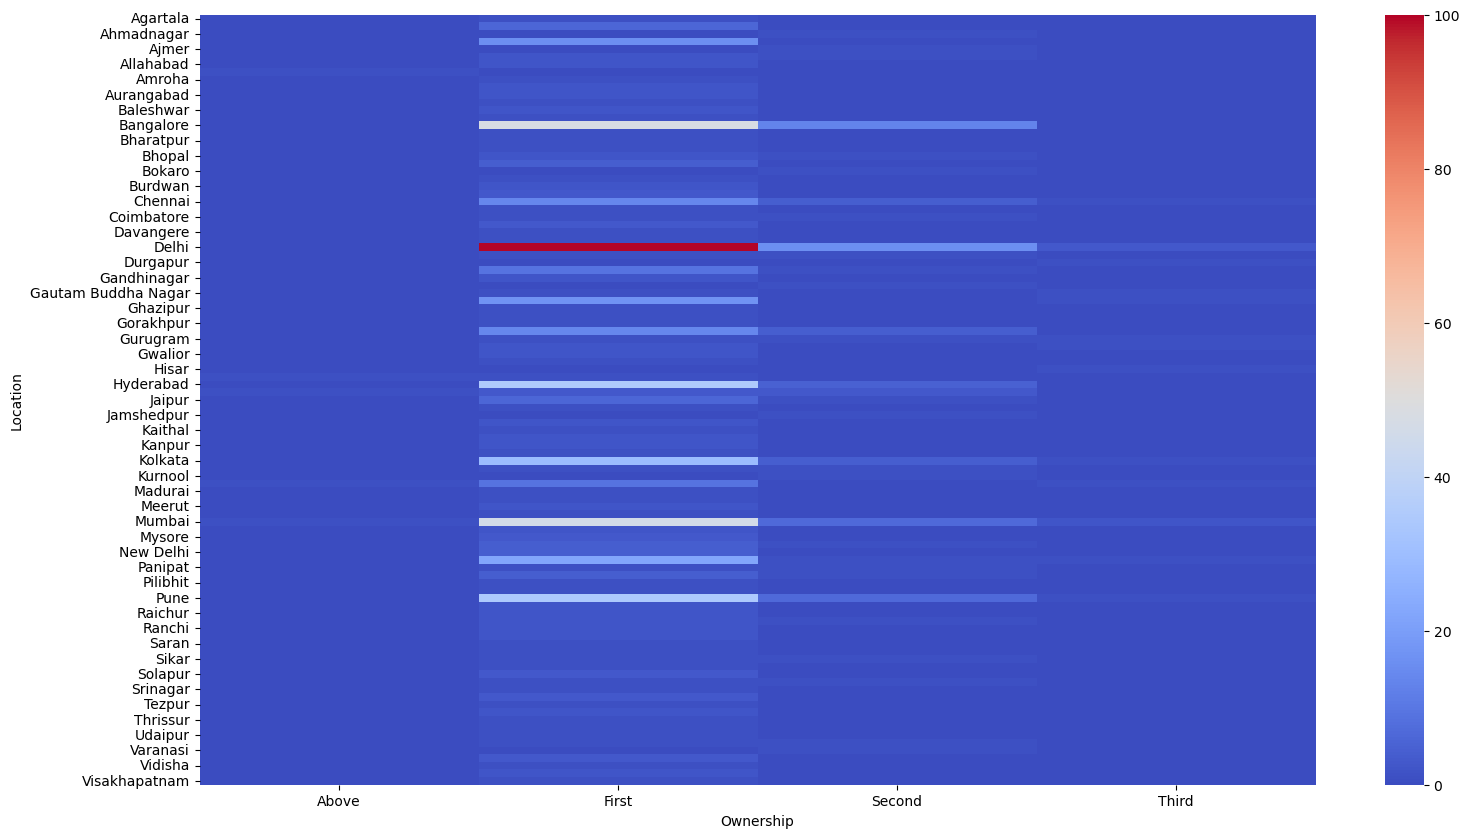

In [41]:
plt.figure(figsize=(18,10))
sns.heatmap(ct,cmap='coolwarm')
plt.show()

## Numerical - Numerical

### Insights

**Scatter Plot (Price vs Km_Driven):**

- Clear negative relationship: bikes with higher kilometers driven are generally priced lower.
- A few outliers exist (very high-priced bikes even at high kilometers, or low-priced bikes with low kilometers). These could be due to premium models, superbikes, or modified/custom bikes that donâ€™t follow the usual depreciation trend.

**Correlation (Pearson = -0.41, Spearman = -0.57):**

- Pearson (-0.41): Moderate linear negative correlation â†’ As Km_Driven increases, Price tends to drop.
- Spearman (-0.57): Stronger monotonic negative correlation â†’ Ranking-wise, bikes with higher kilometers are almost always cheaper, even if not perfectly linear.

### Price - Km_Driven

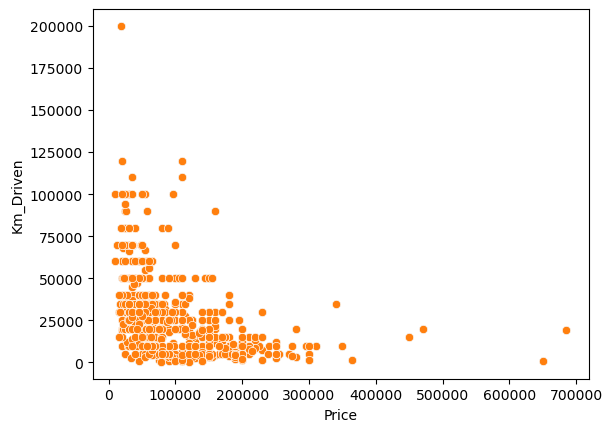

In [60]:
sns.scatterplot(data=df,x='Price',y='Km_Driven')
plt.show()

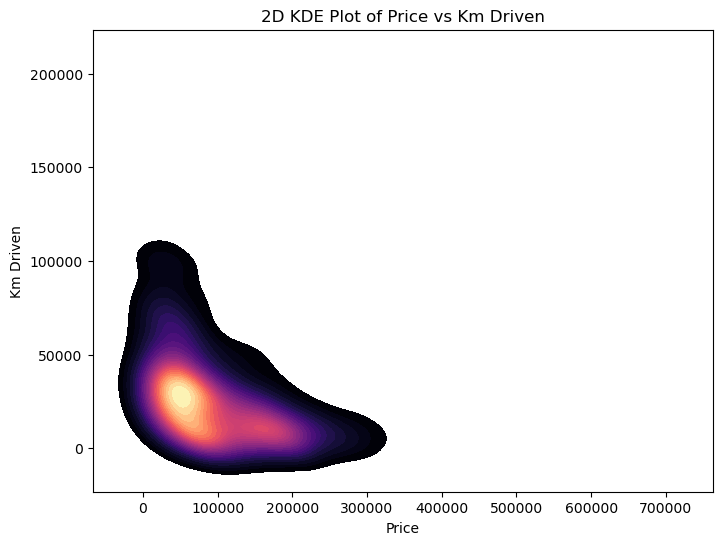

In [64]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df['Price'],
    y=df['Km_Driven'],
    fill=True,
    cmap='magma',# Fills the contours
    thresh=0.05, # Threshold for contour visibility
    levels=30    # Smoothness
)

plt.title("2D KDE Plot of Price vs Km Driven")
plt.xlabel("Price")
plt.ylabel("Km Driven")
plt.show()


In [77]:
corr = df[['Price','Km_Driven']].corr()
corr_s = df[['Price','Km_Driven']].corr(method='spearman')

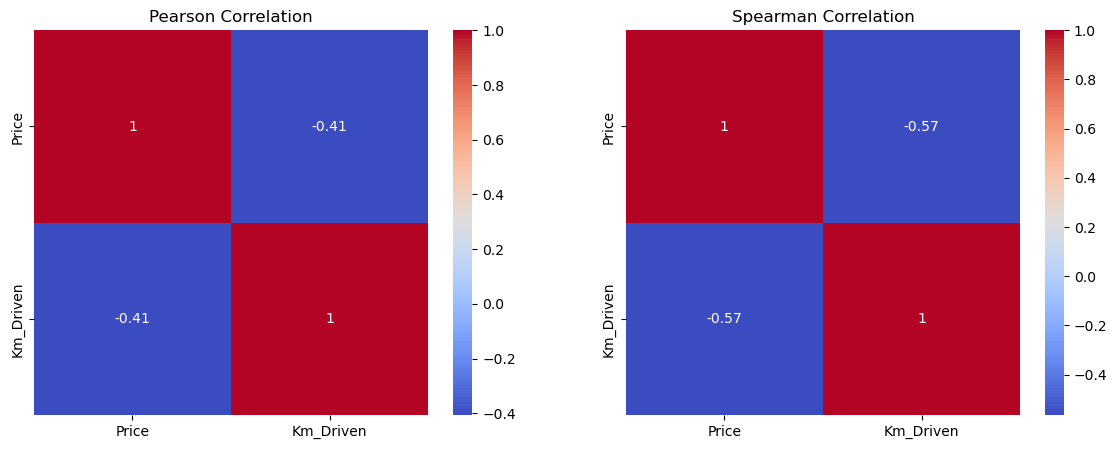

In [83]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
sns.heatmap(corr,annot=True,cmap='coolwarm',ax=ax[0])
sns.heatmap(corr_s,annot=True,cmap='coolwarm',ax=ax[1])
ax[0].set_title("Pearson Correlation")
ax[1].set_title("Spearman Correlation")
plt.show()

## Numerical - Categorical

### Registration_year - Price

### Insights


**Depreciation Effect:**
- Older bikes (2007â€“2012) have much lower resale prices (â‚¹16kâ€“â‚¹28k), while newer bikes (2020â€“2024) retain significantly higher values (â‚¹1.1Lâ€“â‚¹1.48L).

**High Variability in Mid Years:**
- Bikes from 2013â€“2016 show wide price variation due to the presence of both budget and premium/sports models (e.g., 2015 max â‚¹6.85L vs. median ~â‚¹46k).

**Strong Demand for Recent Bikes:**
- Recent models (2021â€“2023) maintain consistently high resale prices, with 2022 peaking due to premium superbikes reaching up to â‚¹6.5L.

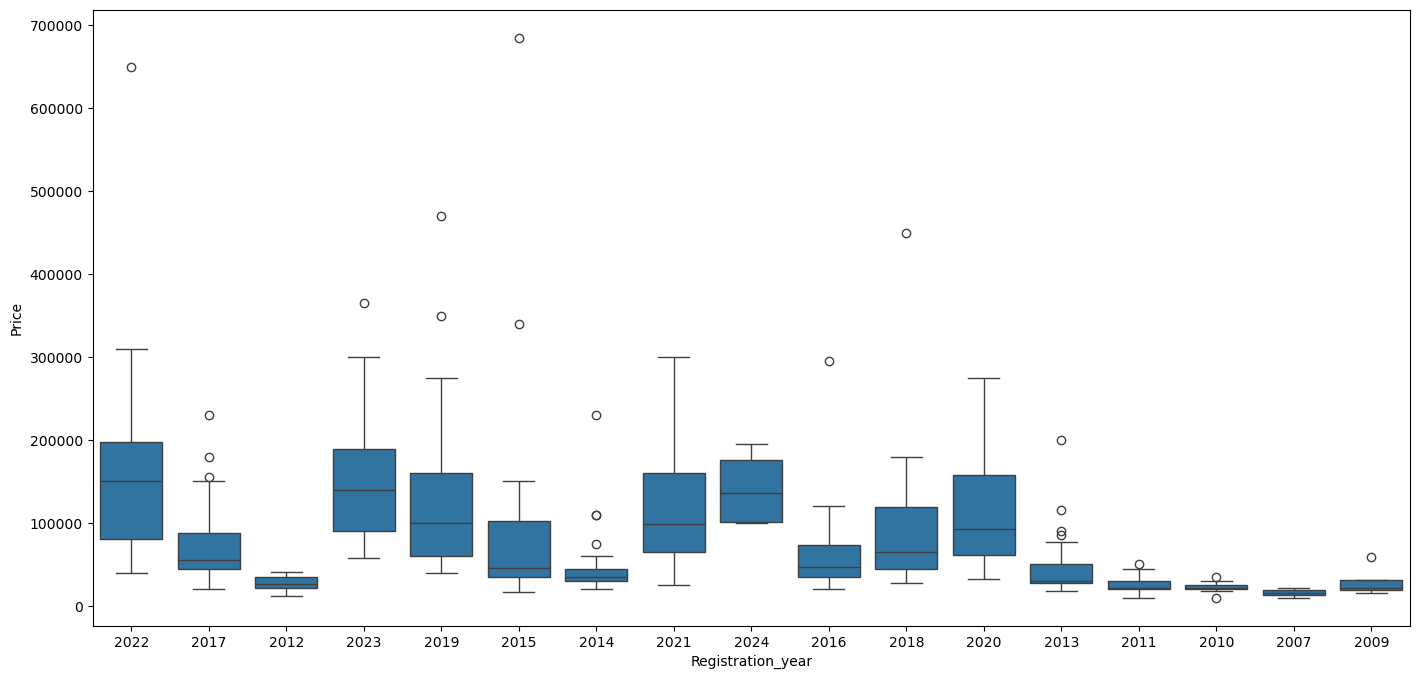

In [90]:
plt.figure(figsize=(17,8))
sns.boxplot(data=df, x="Registration_year", y="Price")
plt.show()

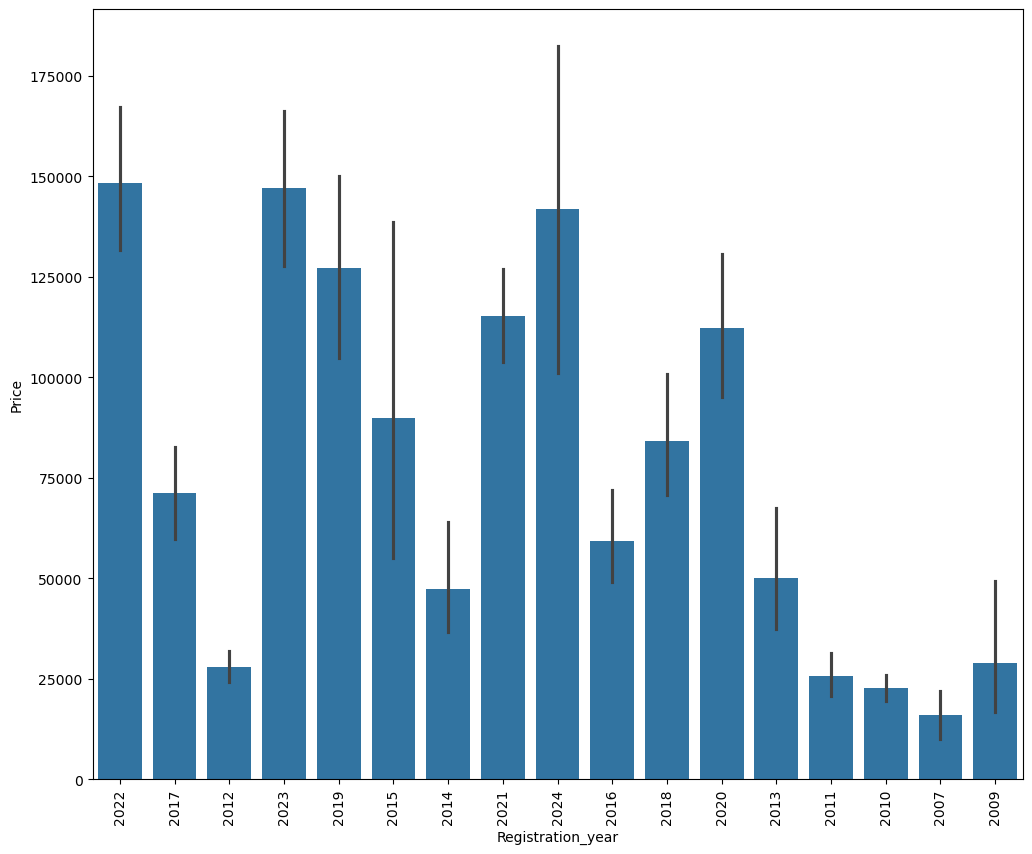

In [96]:
plt.figure(figsize=(12,10))
sns.barplot(data=df, x="Registration_year", y="Price", estimator=np.mean)
plt.xticks(rotation=90)
plt.show()

In [101]:
df.groupby('Registration_year')['Price'].describe()

count           mean            std       min       25%  \
Registration_year                                                            
2007                 2.0   16000.000000    8485.281374   10000.0   13000.0   
2009                 4.0   29000.000000   20215.505600   15000.0   18750.0   
2010                13.0   22692.307692    6303.234823   10000.0   20000.0   
2011                17.0   25705.882353   10693.249657   10000.0   20000.0   
2012                18.0   27944.444444    8720.983635   12000.0   21250.0   
2013                25.0   49983.960000   39845.440124   17599.0   28000.0   
2014                31.0   47419.354839   40509.895247   20000.0   30000.0   
2015                32.0   89890.625000  125236.146898   17000.0   35000.0   
2016                52.0   59336.500000   42291.768523   20000.0   35000.0   
2017                53.0   71242.830189   43601.700672   20000.0   45000.0   
2018                66.0   84067.712121   61718.622784   27000.0   45000.0   
2019                49.0  127163.265306   86091.847015   40000.0   60000.0   
2020                47.0  112242.531915   61866.078958   32000.0   61500.0   
2021                91.0  115142.857143   57851.259744   25000.0   65000.0   
2022                86.0  148395.348837   82775.710997   40000.0   80500.0   
2023                46.0  147071.391304   70504.776950   57285.0   90000.0   
2024                 4.0  141750.000000   48155.131260  100000.0  101500.0   

                        50%       75%       max  
Registration_year                                
2007                16000.0   19000.0   22000.0  
2009                21000.0   31250.0   59000.0  
2010                22000.0   25000.0   35000.0  
2011                22000.0   30000.0   50000.0  
2012                26500.0   35000.0   41000.0  
2013                30000.0   50000.0  200000.0  
2014                35000.0   45000.0  230000.0  
2015                46000.0  102500.0  685000.0  
2016                46500.0   73750.0  295000.0  
2017                55000.0   88000.0  230000.0  
2018                64999.5  118750.0  450000.0  
2019               100000.0  160000.0  470000.0  
2020                93000.0  157500.0  275000.0  
2021                99000.0  160000.0  300000.0  
2022               150000.0  197250.0  650000.0  
2023               139999.5  189250.0  365000.0  
2024               136000.0  176250.0  195000.0

### Brand - Price

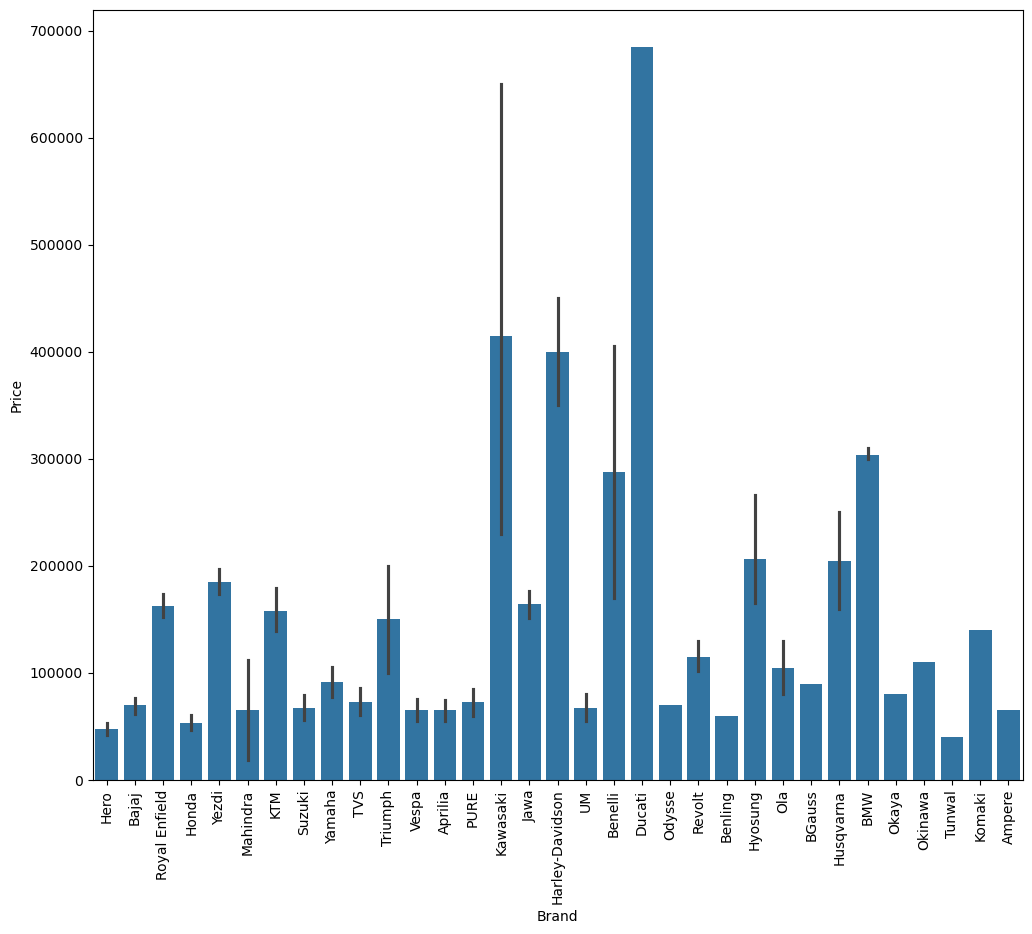

In [105]:
plt.figure(figsize=(12,10))
sns.barplot(data=df, x="Brand", y="Price", estimator=np.mean)
plt.xticks(rotation=90)
plt.show()

In [106]:
df.groupby("Brand")["Price"].describe()

count           mean            std       min       25%  \
Brand                                                                      
Ampere             1.0   65000.000000            NaN   65000.0   65000.0   
Aprilia            7.0   65000.000000   14719.601444   40000.0   57500.0   
BGauss             1.0   90000.000000            NaN   90000.0   90000.0   
BMW                3.0  303333.333333    5773.502692  300000.0  300000.0   
Bajaj            106.0   69668.386792   39764.718840   10000.0   40000.0   
Benelli            4.0  287500.000000  145916.642871  160000.0  175000.0   
Benling            1.0   60000.000000            NaN   60000.0   60000.0   
Ducati             1.0  685000.000000            NaN  685000.0  685000.0   
Harley-Davidson    2.0  400000.000000   70710.678119  350000.0  375000.0   
Hero              64.0   47535.703125   23650.703753   10000.0   30000.0   
Honda            100.0   53015.990000   32895.642343   10000.0   30000.0   
Husqvarna          2.0  205000.000000   63639.610307  160000.0  182500.0   
Hyosung            4.0  206250.000000   62633.191414  150000.0  172500.0   
Jawa              17.0  164000.000000   26741.821180  120000.0  150000.0   
KTM               25.0  158300.000000   52299.617589   83500.0  120000.0   
Kawasaki           3.0  415000.000000  214417.816424  230000.0  297500.0   
Komaki             1.0  140000.000000            NaN  140000.0  140000.0   
Mahindra           4.0   65500.000000   58745.212571   17000.0   19250.0   
Odysse             1.0   70000.000000            NaN   70000.0   70000.0   
Okaya              1.0   80000.000000            NaN   80000.0   80000.0   
Okinawa            1.0  110000.000000            NaN  110000.0  110000.0   
Ola                2.0  105000.000000   35355.339059   80000.0   92500.0   
PURE               2.0   72500.000000   17677.669530   60000.0   66250.0   
Revolt             6.0  115000.000000   18973.665961   95000.0  106250.0   
Royal Enfield     92.0  162719.554348   52157.912196   60000.0  123750.0   
Suzuki            35.0   67019.971429   34636.545661   16000.0   42500.0   
TVS               70.0   72706.985714   56566.503901   15000.0   37000.0   
Triumph            2.0  150000.000000   70710.678119  100000.0  125000.0   
Tunwal             1.0   40000.000000            NaN   40000.0   40000.0   
UM                 2.0   67500.000000   17677.669530   55000.0   61250.0   
Vespa             11.0   64999.909091   18708.367115   35000.0   60000.0   
Yamaha            52.0   91846.153846   53041.376603   20000.0   44250.0   
Yezdi             12.0  185000.000000   23061.183444  150000.0  168750.0   

                      50%       75%       max  
Brand                                          
Ampere            65000.0   65000.0   65000.0  
Aprilia           65000.0   77500.0   80000.0  
BGauss            90000.0   90000.0   90000.0  
BMW              300000.0  305000.0  310000.0  
Bajaj             60000.0   88875.0  175000.0  
Benelli          260000.0  372500.0  470000.0  
Benling           60000.0   60000.0   60000.0  
Ducati           685000.0  685000.0  685000.0  
Harley-Davidson  400000.0  425000.0  450000.0  
Hero              42000.0   65000.0  130000.0  
Honda             45000.0   60000.0  192000.0  
Husqvarna        205000.0  227500.0  250000.0  
Hyosung          190000.0  223750.0  295000.0  
Jawa             168000.0  190000.0  210000.0  
KTM              160000.0  185000.0  280000.0  
Kawasaki         365000.0  507500.0  650000.0  
Komaki           140000.0  140000.0  140000.0  
Mahindra          52500.0   98750.0  140000.0  
Odysse            70000.0   70000.0   70000.0  
Okaya             80000.0   80000.0   80000.0  
Okinawa          110000.0  110000.0  110000.0  
Ola              105000.0  117500.0  130000.0  
PURE              72500.0   78750.0   85000.0  
Revolt           110000.0  117500.0  150000.0  
Royal Enfield    162500.0  200000.0  300000.0  
Suzuki            50000.0   99000.0  150000.0  
TVS         

### Price - Ownership

**First Ownership Dominates**
- The majority of bikes are first-hand (529 records), and they command the highest average resale price (~â‚¹97.6K), reflecting stronger buyer preference for single-owner bikes.

**Higher Variability in Multi-Owner Bikes**
- Second and third-owner bikes show much higher price variability (std ~â‚¹97Kâ€“â‚¹118K) compared to first-owner bikes, indicating inconsistent valuation depending on condition and model.

**Premium Retention Possible Even After Multiple Owners**
- Although prices generally decline with more owners, second and third-owner bikes still reach very high maximum values (â‚¹6.85L and â‚¹4.7L), showing that premium/sports bikes retain strong resale value regardless of ownership count.

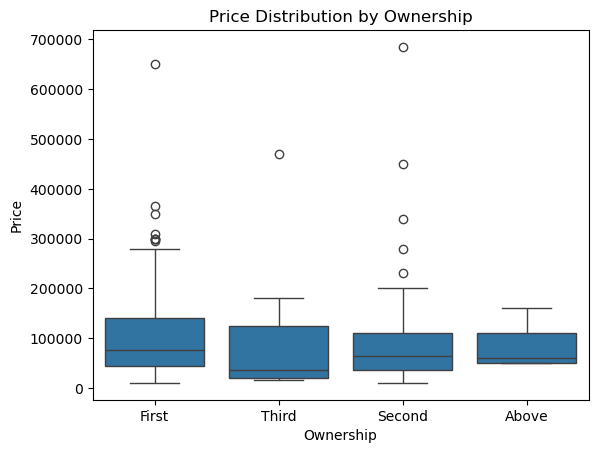

In [15]:
sns.boxplot(x=df['Ownership'],y=df['Price'])
plt.title("Price Distribution by Ownership")
plt.show()

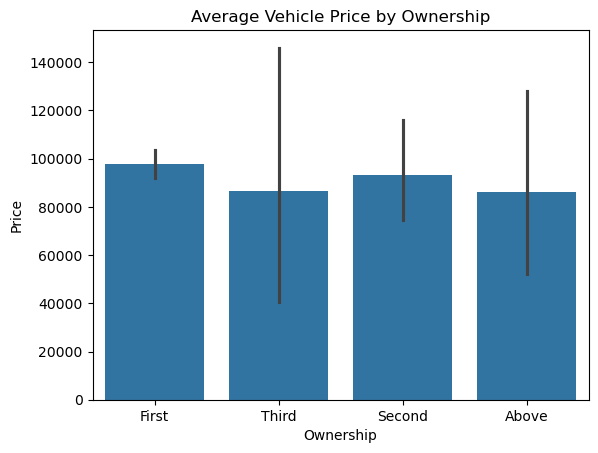

In [14]:
sns.barplot(x=df['Ownership'],y=df['Price'],estimator=np.mean)
plt.title("Average Vehicle Price by Ownership")
plt.show()

In [24]:
df.groupby('Ownership')["Price"].describe()

count          mean            std      min      25%      50%  \
Ownership                                                                  
Above        5.0  85999.800000   48270.259997  49999.0  50000.0  60000.0   
First      529.0  97619.892250   70063.460272  10000.0  45000.0  77000.0   
Second      86.0  93152.302326   97823.527613  10000.0  36250.0  65000.0   
Third       16.0  86599.937500  117878.168180  15000.0  19500.0  35000.0   

                75%       max  
Ownership                      
Above      110000.0  160000.0  
First      140000.0  650000.0  
Second     110000.0  685000.0  
Third      125000.0  470000.0

### Price - Location

### Insights

- Wide price variability in metro cities (like Bangalore, Hyderabad, Mumbai, and Delhi), showing that these markets have both budget and premium bikes.

- Some locations (e.g., Ranchi, Surat, Vishakhapatnam) have significantly higher median prices, suggesting stronger demand for mid-to-high-end bikes there.

- Many tier-2/3 cities show tighter price ranges, indicating more uniform pricing with fewer premium outliers compared to metros.

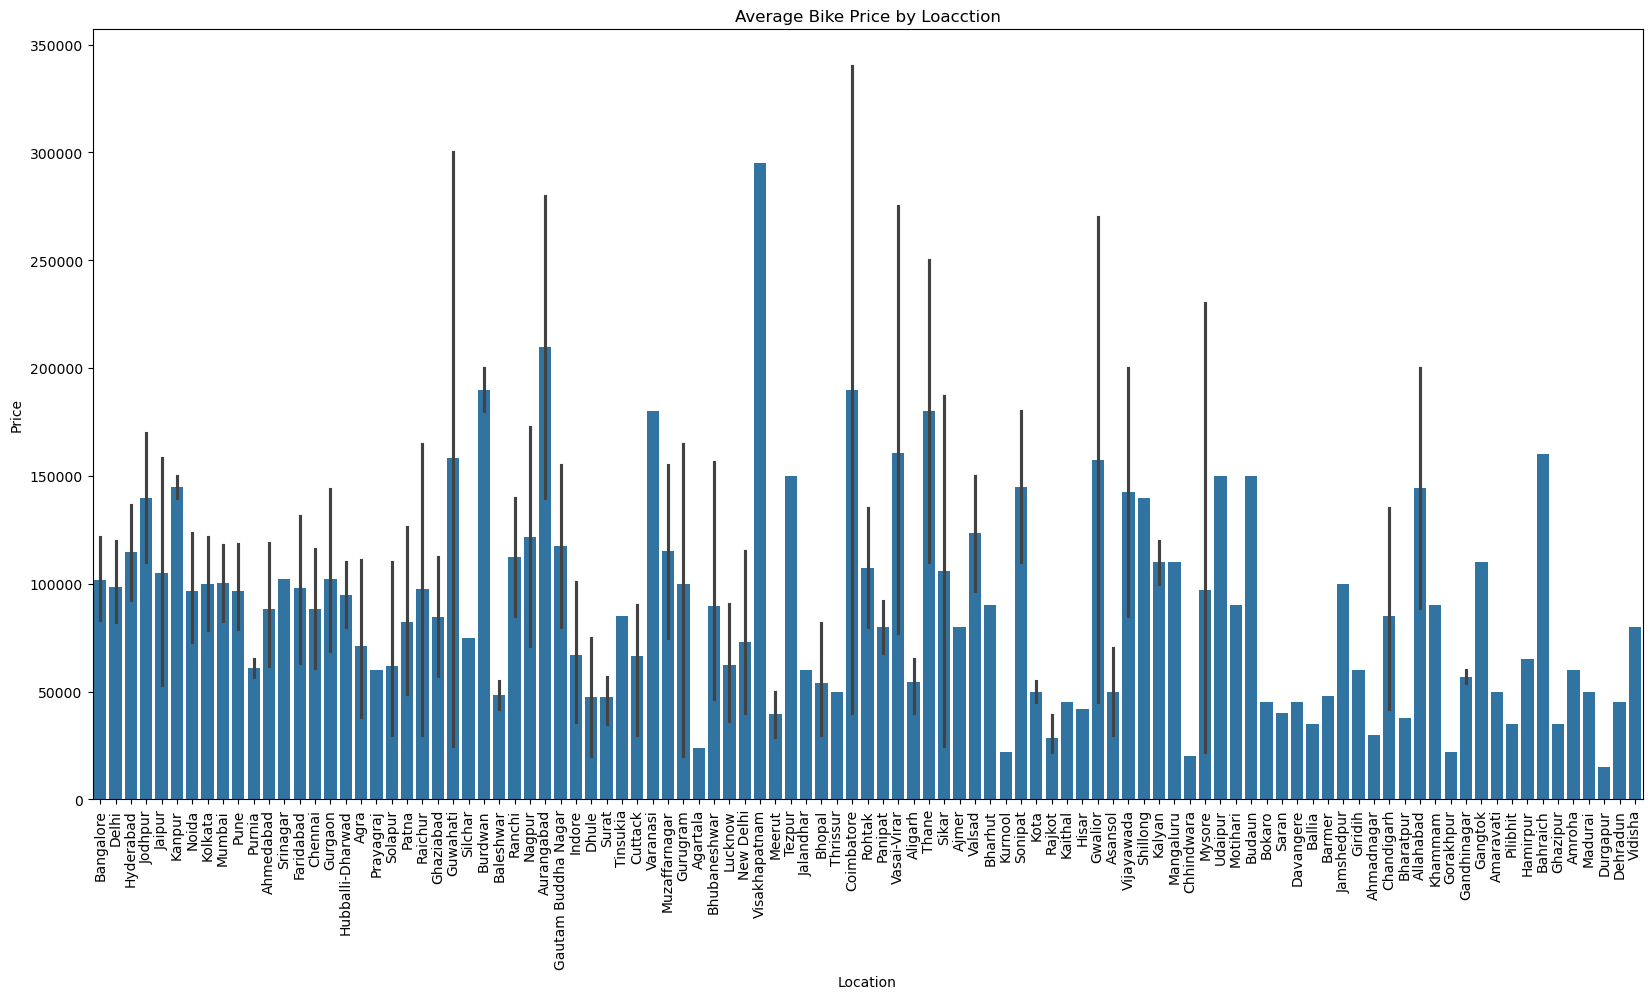

In [33]:
plt.figure(figsize=(20,10))
sns.barplot(x=df['Location'],y=df['Price'],estimator=np.mean)
plt.xticks(rotation = 90)
plt.title("Average Bike Price by Loacction")
plt.show()

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

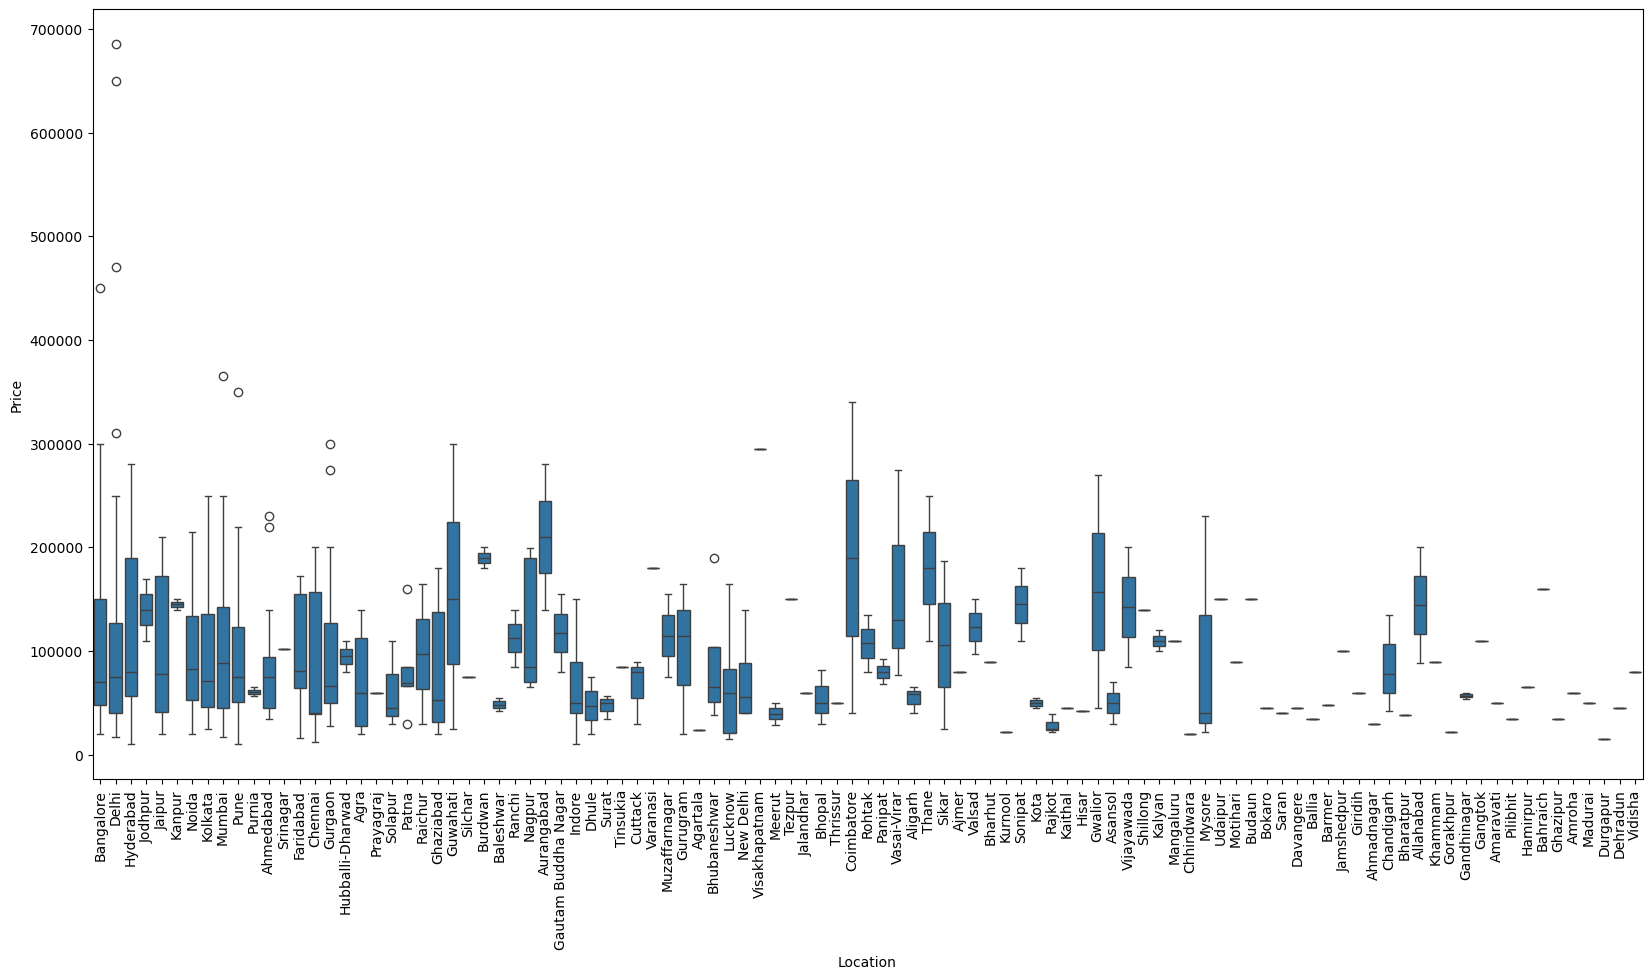

In [36]:
plt.figure(figsize=(20,10))
sns.boxplot(y=df["Price"],x=df["Location"])
plt.xticks(rotation = 90)
plt.show()

### Km_Driven - Registration_year

### Insights

- Older bikes (2007â€“2012) show much higher average kilometers driven (40kâ€“62k km), reflecting long usage before resale.

- Recent models (2018â€“2024) have much lower average km driven (below 20k), as they are newer and likely resold earlier.

- High variability in mid-years (2011â€“2016) suggests mixed usage patterns â€” some bikes driven extensively (100kâ€“200k km), while others were lightly used before resale.

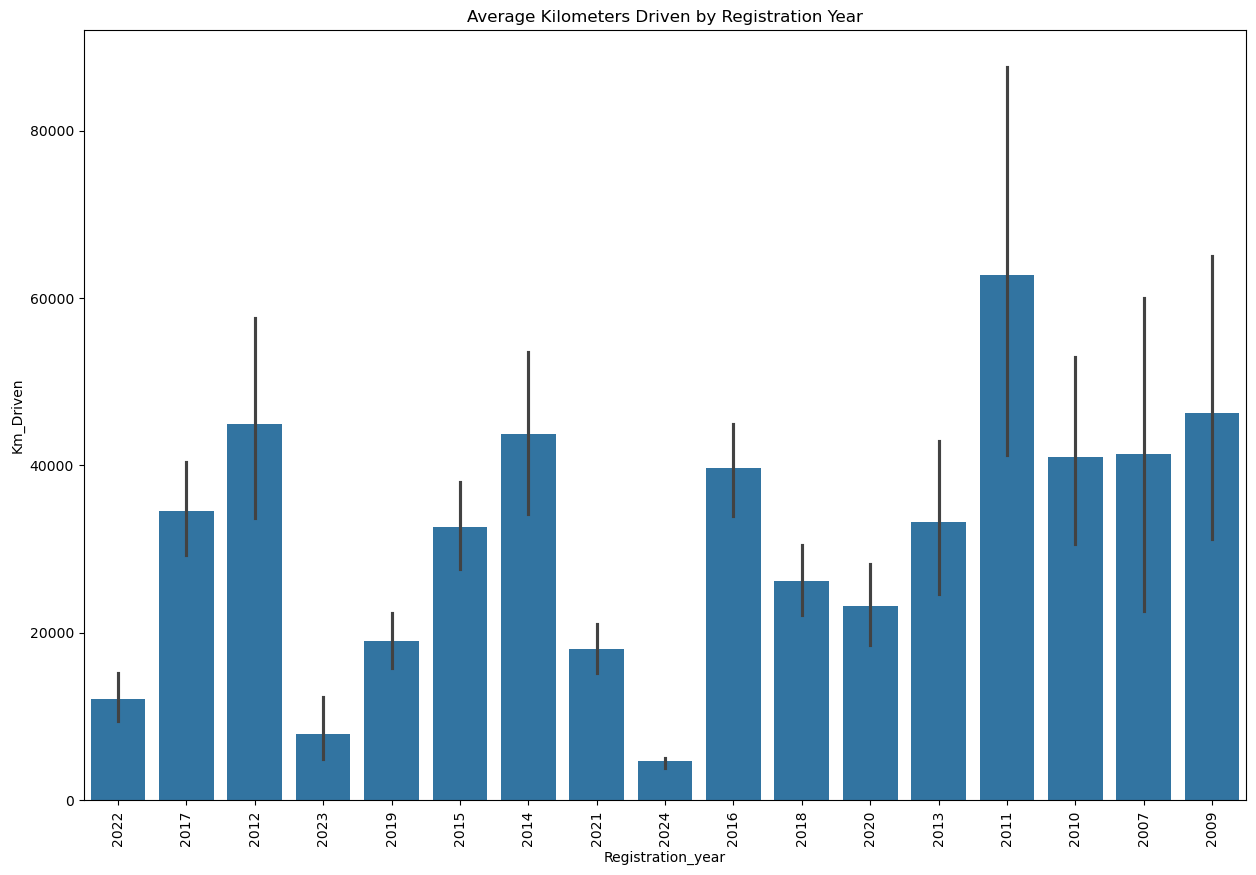

In [82]:
plt.figure(figsize=(15,10))
sns.barplot(x=df['Registration_year'],y=df['Km_Driven'],estimator=np.mean)
plt.xticks(rotation = 90)
plt.title("Average Kilometers Driven by Registration Year")
plt.show()

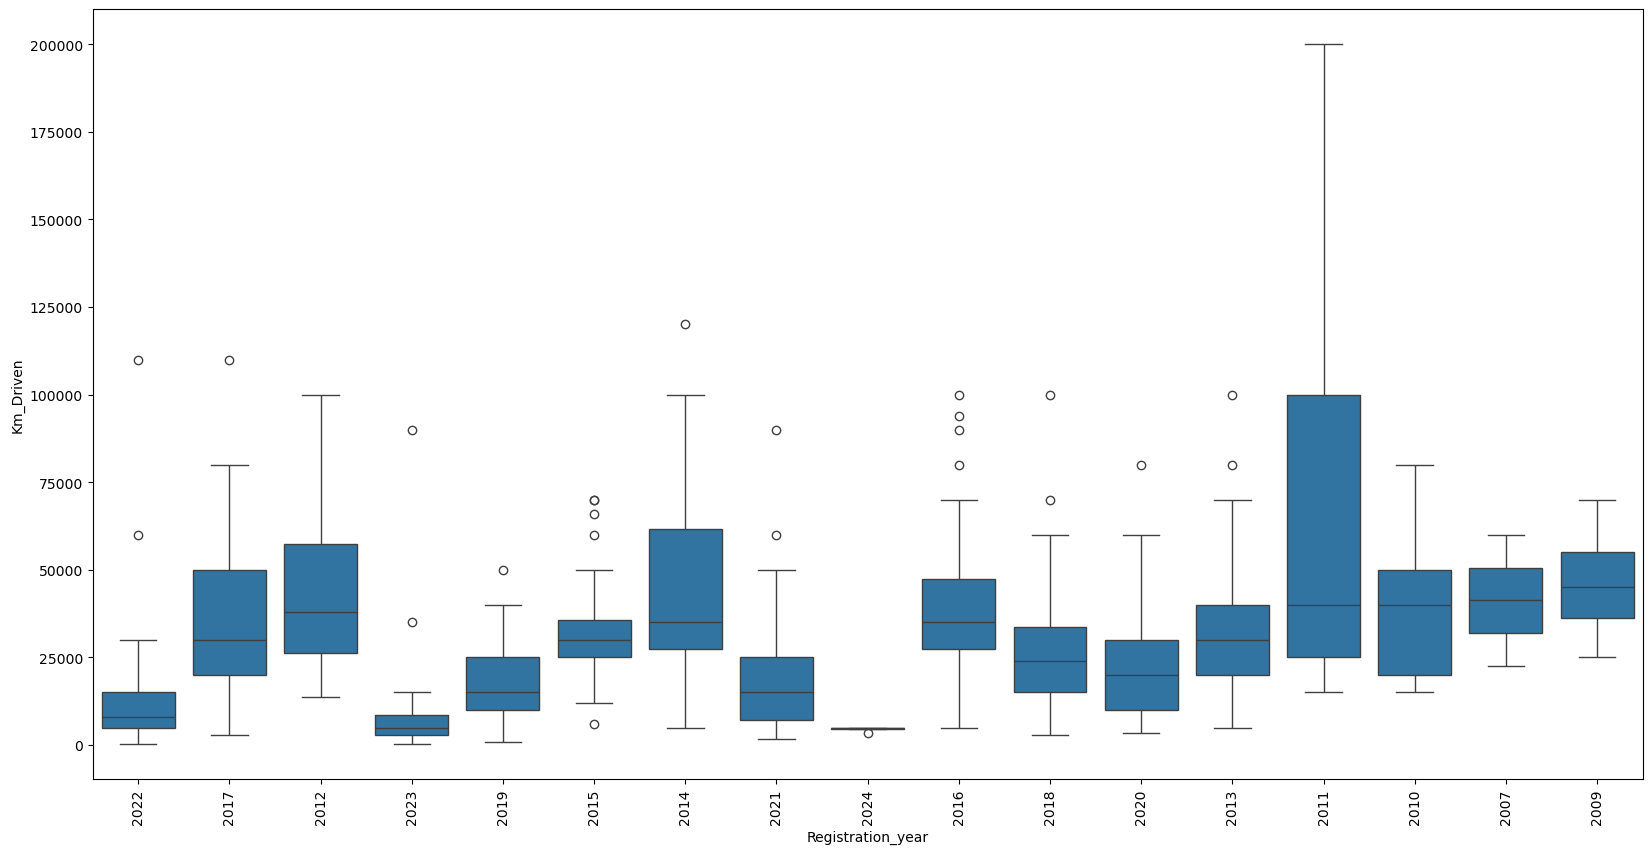

In [83]:
plt.figure(figsize=(20,10))
sns.boxplot(y=df["Km_Driven"],x=df["Registration_year"])
plt.xticks(rotation = 90)
plt.show()

In [84]:
df.groupby("Registration_year")['Km_Driven'].describe()

count          mean           std      min      25%  \
Registration_year                                                        
2007                 2.0  41300.000000  26445.793616  22600.0  31950.0   
2009                 4.0  46250.000000  18874.586088  25000.0  36250.0   
2010                13.0  41041.923077  22370.946890  15000.0  20000.0   
2011                17.0  62794.117647  50343.525783  15000.0  25000.0   
2012                18.0  44948.111111  27278.909373  13725.0  26125.0   
2013                25.0  33258.400000  22929.704177   5000.0  20000.0   
2014                31.0  43725.806452  26662.032527   5000.0  27500.0   
2015                32.0  32659.750000  15672.772633   6000.0  25000.0   
2016                52.0  39647.576923  20988.181605   5000.0  27375.0   
2017                53.0  34558.056604  20533.773066   2800.0  20000.0   
2018                66.0  26196.833333  17489.423494   3000.0  15000.0   
2019                49.0  19002.653061  12099.142321    880.0  10000.0   
2020                47.0  23180.106383  16356.287191   3500.0  10000.0   
2021                91.0  18045.109890  14433.887152   1600.0   7100.0   
2022                86.0  12108.825581  14305.582204    273.0   5000.0   
2023                46.0   7855.978261  13661.738120    350.0   2850.0   
2024                 4.0   4625.000000    750.000000   3500.0   4625.0   

                       50%       75%       max  
Registration_year                               
2007               41300.0   50650.0   60000.0  
2009               45000.0   55000.0   70000.0  
2010               40000.0   50000.0   80000.0  
2011               40000.0  100000.0  200000.0  
2012               38000.0   57500.0  100000.0  
2013               30000.0   40000.0  100000.0  
2014               35000.0   61750.0  120000.0  
2015               30000.0   35650.0   70000.0  
2016               35000.0   47375.0  100000.0  
2017               30000.0   50000.0  110000.0  
2018               24000.0   33750.0  100000.0  
2019               15000.0   25000.0   50000.0  
2020               20000.0   30000.0   80000.0  
2021               15000.0   25000.0   90000.0  
2022                8000.0   15000.0  110000.0  
2023                5000.0    8625.0   90000.0  
2024                5000.0    5000.0    5000.0

### Brand - Km_Driven

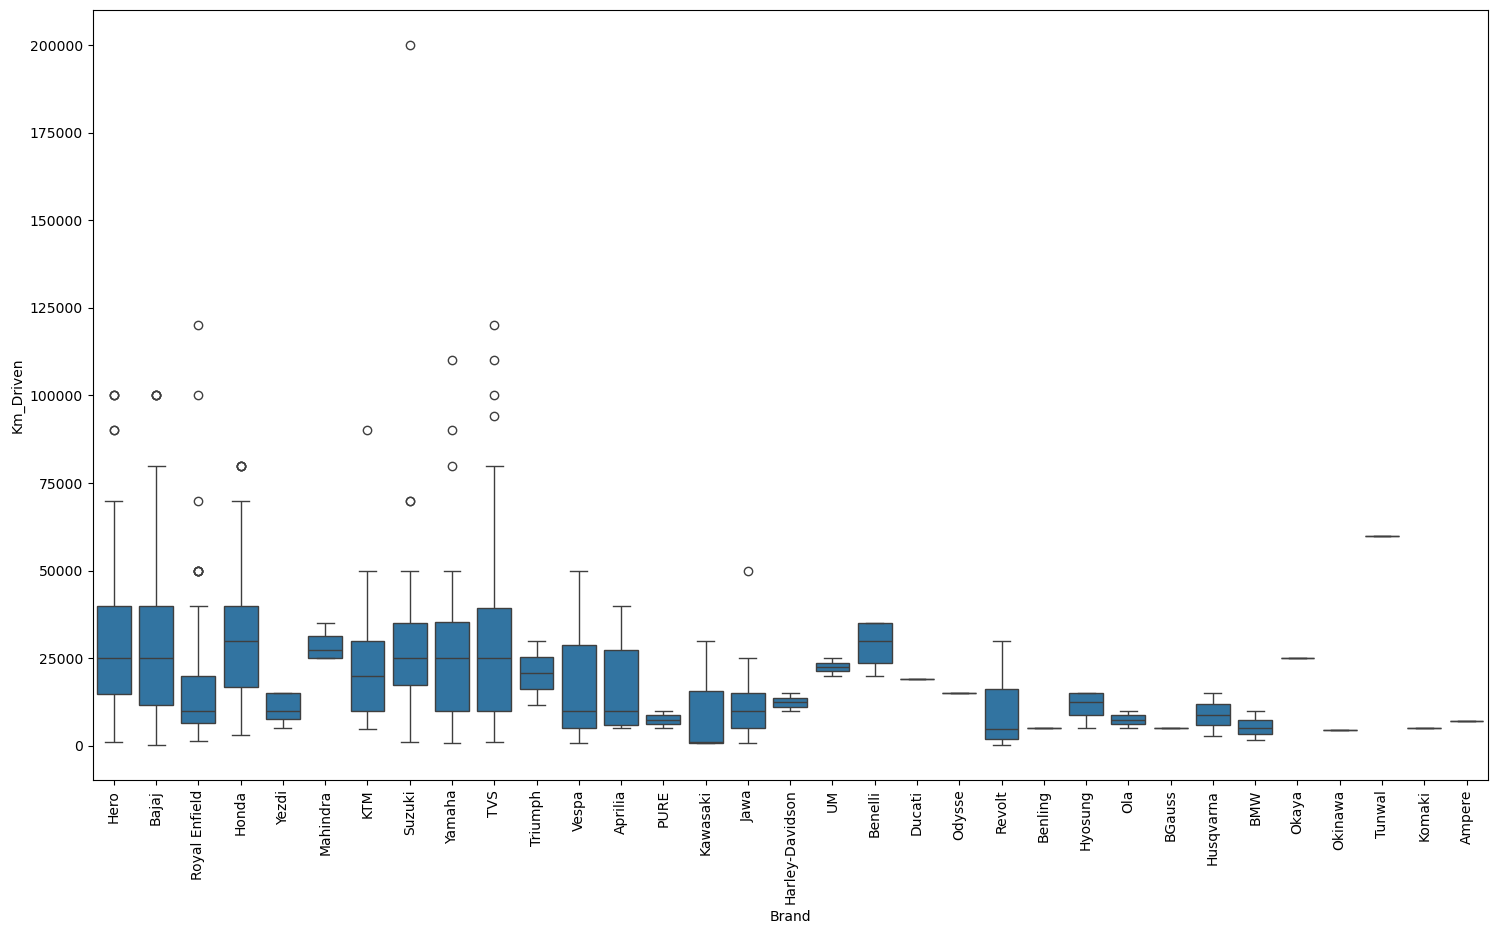

In [9]:
plt.figure(figsize=(18,10))
sns.boxplot(y=df["Km_Driven"],x=df["Brand"])
plt.xticks(rotation = 90)
plt.show()

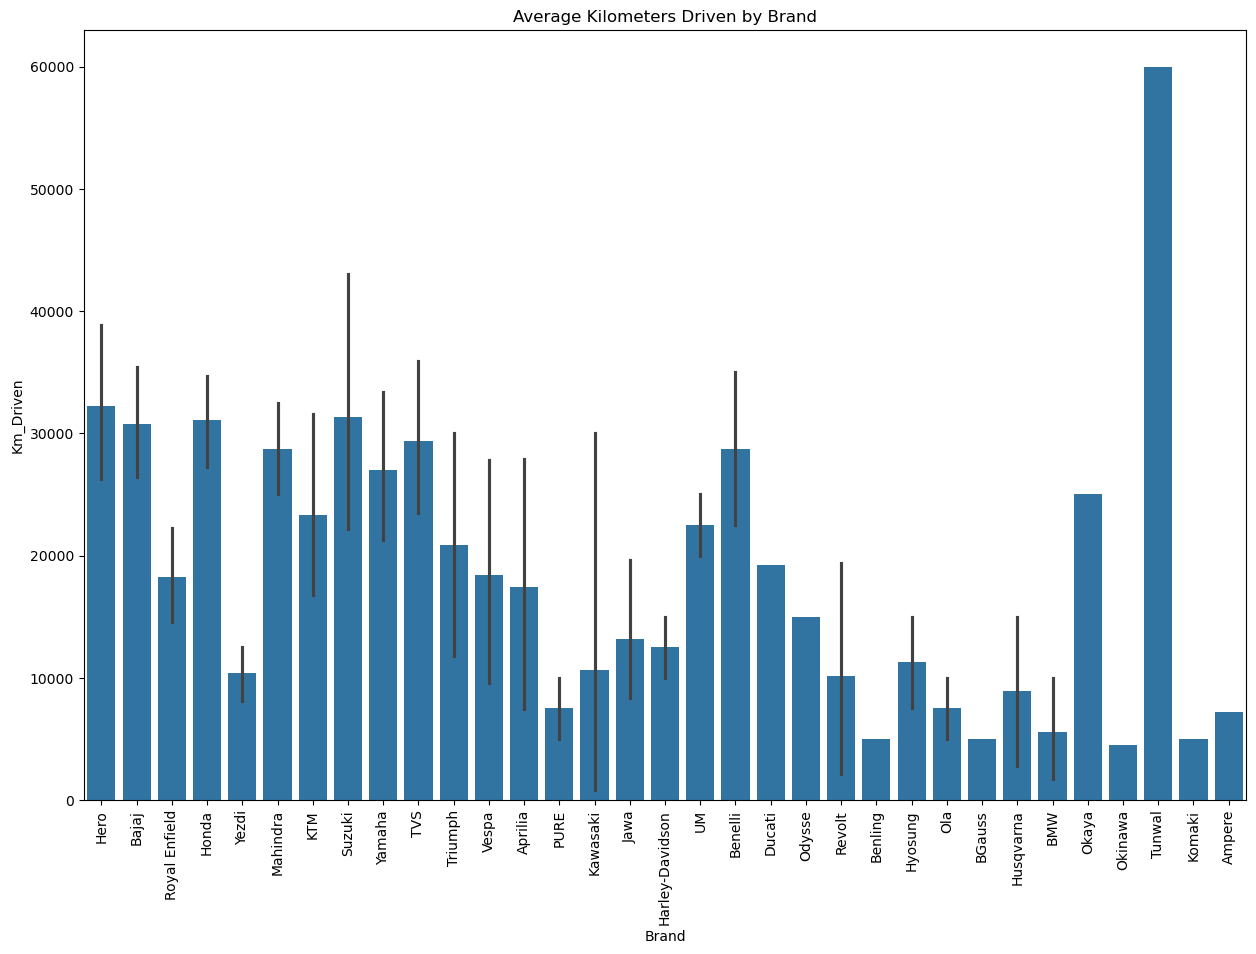

In [11]:
plt.figure(figsize=(15,10))
sns.barplot(x=df['Brand'],y=df['Km_Driven'],estimator=np.mean)
plt.xticks(rotation = 90)
plt.title("Average Kilometers Driven by Brand")
plt.show()

In [14]:
df.groupby('Brand')['Km_Driven'].describe()

count          mean           std      min       25%  \
Brand                                                                   
Ampere             1.0   7200.000000           NaN   7200.0   7200.00   
Aprilia            7.0  17428.571429  14128.660503   5000.0   6000.00   
BGauss             1.0   5000.000000           NaN   5000.0   5000.00   
BMW                3.0   5566.666667   4178.915330   1700.0   3350.00   
Bajaj            106.0  30788.811321  23766.588079    350.0  11575.00   
Benelli            4.0  28750.000000   7500.000000  20000.0  23750.00   
Benling            1.0   5000.000000           NaN   5000.0   5000.00   
Ducati             1.0  19200.000000           NaN  19200.0  19200.00   
Harley-Davidson    2.0  12500.000000   3535.533906  10000.0  11250.00   
Hero              64.0  32223.562500  25694.249969   1000.0  14750.00   
Honda            100.0  31070.440000  19402.152536   3000.0  16772.75   
Husqvarna          2.0   8900.000000   8626.702730   2800.0   5850.00   
Hyosung            4.0  11250.000000   4787.135539   5000.0   8750.00   
Jawa              17.0  13175.294118  11426.783295    880.0   5000.00   
KTM               25.0  23354.960000  19001.767419   4700.0  10000.00   
Kawasaki           3.0  10641.666667  16765.595973    800.0    962.50   
Komaki             1.0   5000.000000           NaN   5000.0   5000.00   
Mahindra           4.0  28750.000000   4787.135539  25000.0  25000.00   
Odysse             1.0  15000.000000           NaN  15000.0  15000.00   
Okaya              1.0  25000.000000           NaN  25000.0  25000.00   
Okinawa            1.0   4500.000000           NaN   4500.0   4500.00   
Ola                2.0   7500.000000   3535.533906   5000.0   6250.00   
PURE               2.0   7500.000000   3535.533906   5000.0   6250.00   
Revolt             6.0  10162.166667  12059.409113    273.0   2025.00   
Royal Enfield     92.0  18258.434783  19341.132270   1350.0   6410.00   
Suzuki            35.0  31338.542857  33444.475762   1000.0  17500.00   
TVS               70.0  29371.571429  26759.117511   1010.0  10000.00   
Triumph            2.0  20900.000000  12869.343418  11800.0  16350.00   
Tunwal             1.0  60000.000000           NaN  60000.0  60000.00   
UM                 2.0  22500.000000   3535.533906  20000.0  21250.00   
Vespa             11.0  18440.909091  16393.974780    700.0   5000.00   
Yamaha            52.0  26970.307692  22076.757659    850.0  10000.00   
Yezdi             12.0  10425.000000   4011.829100   5000.0   7700.00   

                     50%      75%       max  
Brand                                        
Ampere            7200.0   7200.0    7200.0  
Aprilia          10000.0  27500.0   40000.0  
BGauss            5000.0   5000.0    5000.0  
BMW               5000.0   7500.0   10000.0  
Bajaj            25000.0  40000.0  100000.0  
Benelli          30000.0  35000.0   35000.0  
Benling           5000.0   5000.0    5000.0  
Ducati           19200.0  19200.0   19200.0  
Harley-Davidson  12500.0  13750.0   15000.0  
Hero             25000.0  40000.0  100000.0  
Honda            30000.0  40000.0   80000.0  
Husqvarna         8900.0  11950.0   15000.0  
Hyosung          12500.0  15000.0   15000.0  
Jawa             10000.0  15000.0   50000.0  
KTM              20000.0  30000.0   90000.0  
Kawasaki          1125.0  15562.5   30000.0  
Komaki            5000.0   5000.0    5000.0  
Mahindra         27500.0  31250.0   35000.0  
Odysse           15000.0  15000.0   15000.0  
Okaya            25000.0  25000.0   25000.0  
Okinawa           4500.0   4500.0    4500.0  
Ola               7500.0   8750.0   10000.0  
PURE              7500.0   8750.0   10000.0  
Revolt            4750.0  16250.0   30000.0  
Royal Enfield    10000.0  20000.0  120000.0  
Suzuki           25000.0  35000.0  200000.0  
TVS              25000.0  39250.0  120000.0  
Triumph          20900.0  25450.0   30000.0  
Tunwal           60000.0  60000.0   60000.0  
UM               22500.0  23750.0  

### Ownership - Km_Driven

### Insights

- Mass-market brands (Bajaj, Hero, Honda, TVS, Yamaha, Suzuki) show higher average km driven (27kâ€“32k), indicating longer daily usage and stronger resale market.

- Premium / performance brands (Royal Enfield, KTM, Jawa, Benelli, Triumph, Ducati, Harley, etc.) generally have lower average km driven (10kâ€“23k) â€” buyers may use them less frequently (weekend rides, leisure).

- Electric brands (Ola, Okinawa, Ampere, Benling, PURE, etc.) show very low km driven (5kâ€“7k), reflecting their recent entry into the market and limited long-distance usage.

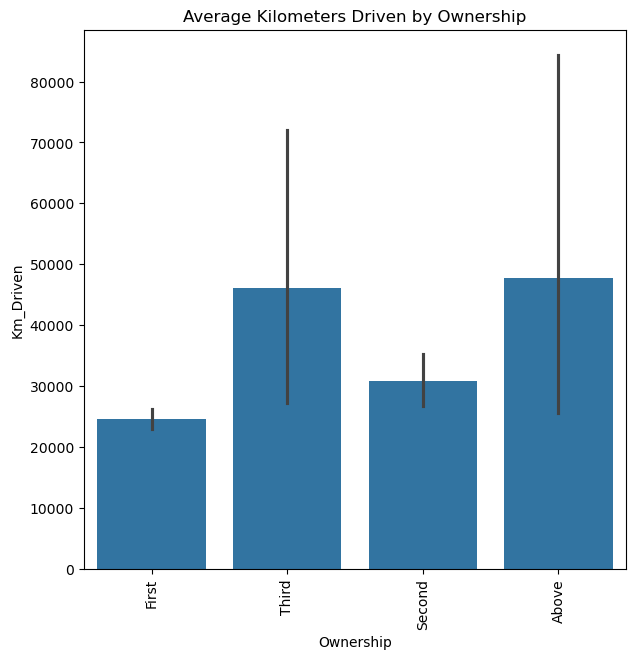

In [17]:
plt.figure(figsize=(7,7))
sns.barplot(x=df['Ownership'],y=df['Km_Driven'],estimator=np.mean)
plt.xticks(rotation = 90)
plt.title("Average Kilometers Driven by Ownership")
plt.show()

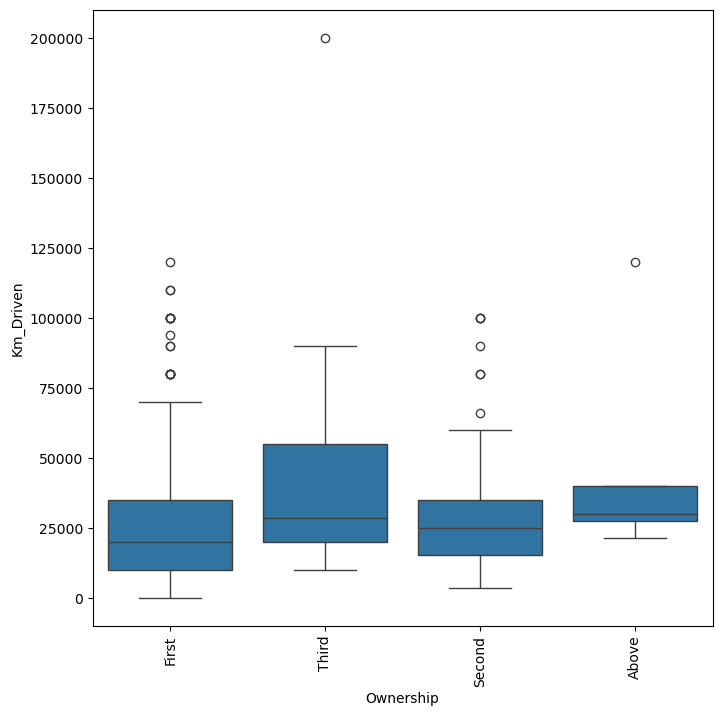

In [19]:
plt.figure(figsize=(8,8))
sns.boxplot(y=df["Km_Driven"],x=df["Ownership"])
plt.xticks(rotation = 90)
plt.show()

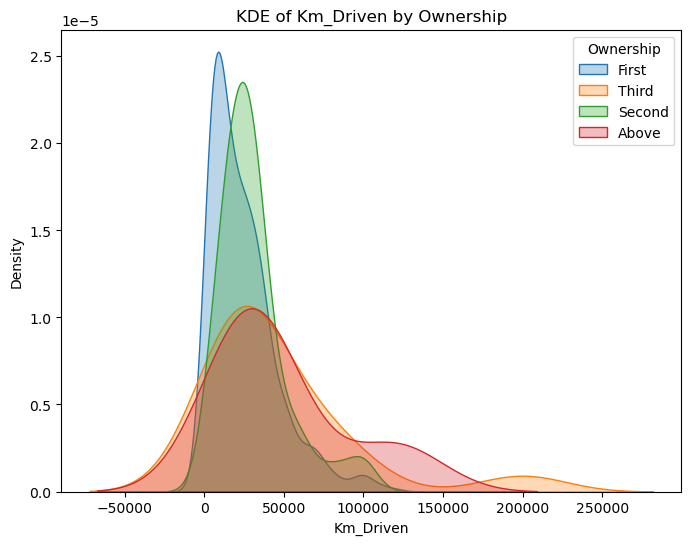

In [20]:
plt.figure(figsize=(8,6))

# Loop through each ownership category and plot its KDE
for ownership in df['Ownership'].unique():
    subset = df[df['Ownership'] == ownership]
    sns.kdeplot(subset['Km_Driven'], label=ownership, fill=True, alpha=0.3)

plt.xlabel("Km_Driven")
plt.ylabel("Density")
plt.title("KDE of Km_Driven by Ownership")
plt.legend(title="Ownership")
plt.show()


In [22]:
df.groupby('Ownership')['Km_Driven'].describe()

count          mean           std      min      25%      50%  \
Ownership                                                                 
Above        5.0  47800.000000  40909.351009  21500.0  27500.0  30000.0   
First      529.0  24547.701323  21339.511966    273.0  10000.0  20000.0   
Second      86.0  30857.267442  21742.403293   3900.0  15500.0  25000.0   
Third       16.0  46093.750000  47652.988276  10000.0  20000.0  28750.0   

               75%       max  
Ownership                     
Above      40000.0  120000.0  
First      35000.0  120000.0  
Second     35000.0  100000.0  
Third      55000.0  200000.0

### Location - Km_Driven

### Insights

**High-usage cities:**

- Locations like Delhi, Hyderabad, Pune, Bangalore, Gurgaon show higher median and wider spread of Km Driven â†’ indicates bikes are used heavily for commuting, possibly due to urban lifestyle and long travel distances.

**Outliers present:**

- Some cities (like Delhi, Ahmedabad, Bangalore) have outliers beyond 1,00,000 â€“ 2,00,000 km, suggesting commercial use or long-distance commuting.

**Low-usage cities:**

- Smaller cities such as Ajmer, Bareilly, Ranchi, Gwalior, Asansol show lower medians and tighter ranges (around 15kâ€“30k km) â†’ indicates bikes are used less intensively, maybe short-distance or rural commute.

**Variation across regions:**

- Metro cities = high variability in usage.
- Tier-2/Tier-3 cities = more consistent (narrow boxes), suggesting similar riding habits in those regions.

**EV/urban adoption hint:**

- Some cities show very low km (5kâ€“10k median), likely because electric scooters or newer vehicles dominate recent sales there.

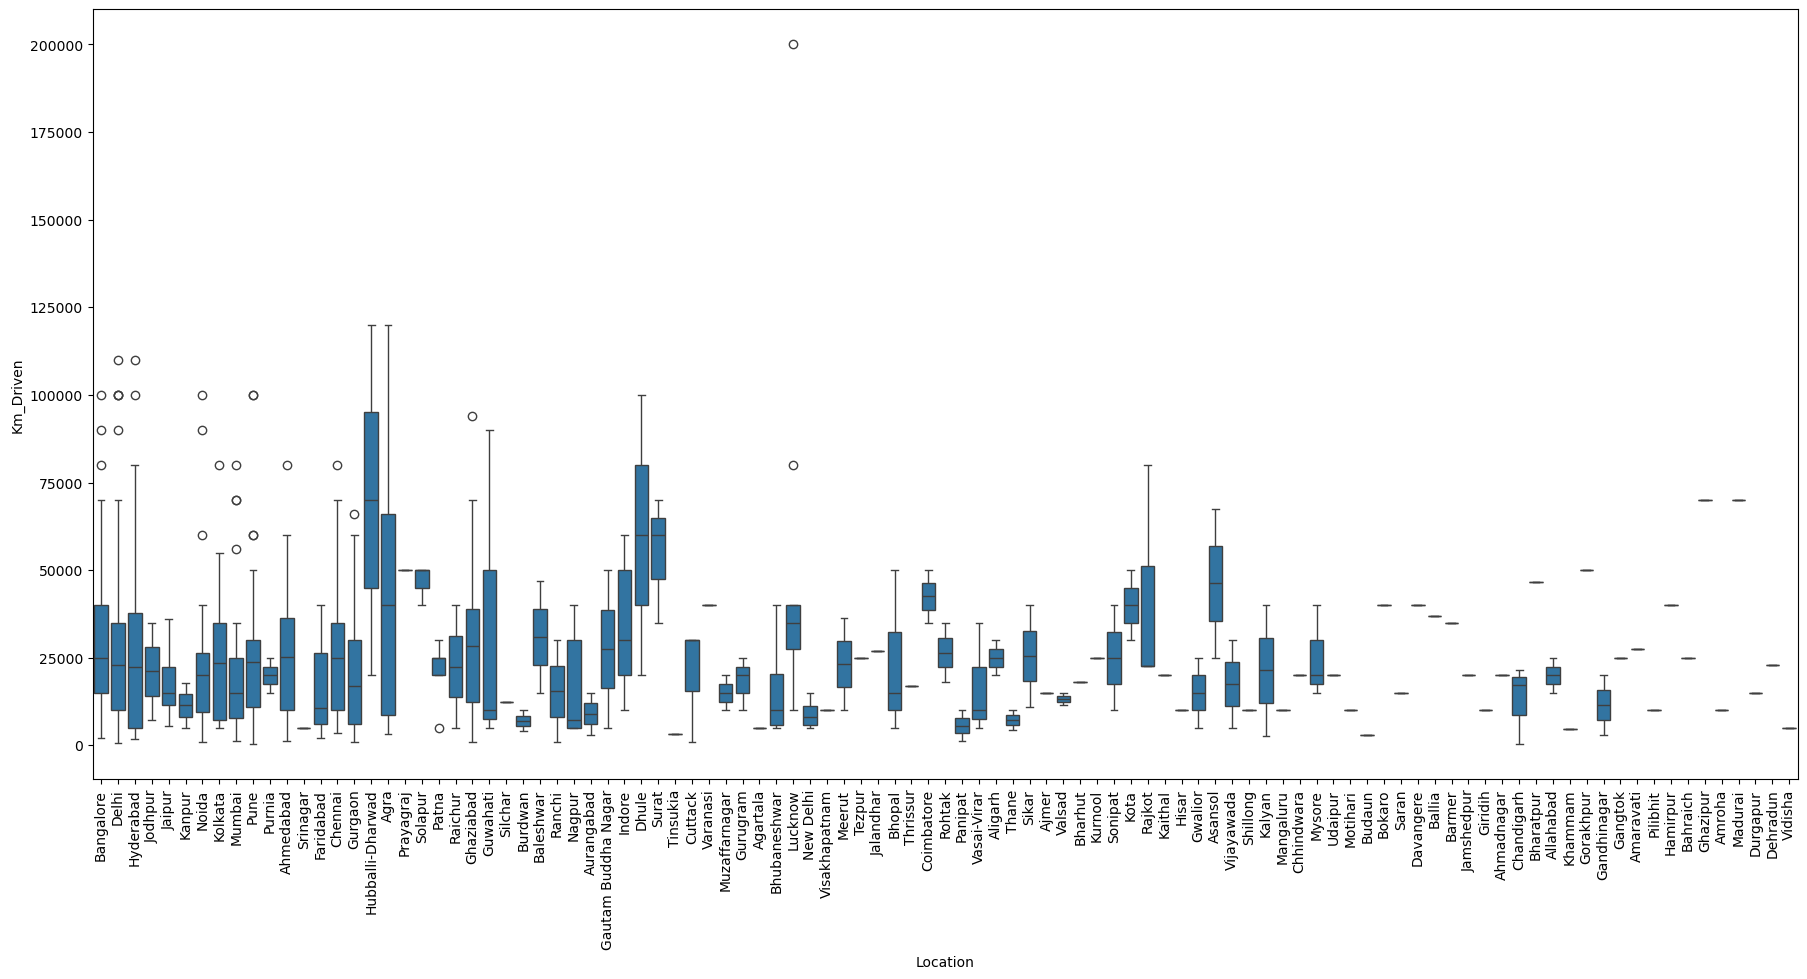

In [24]:
plt.figure(figsize=(22,10))
sns.boxplot(y=df["Km_Driven"],x=df["Location"])
plt.xticks(rotation = 90)
plt.show()

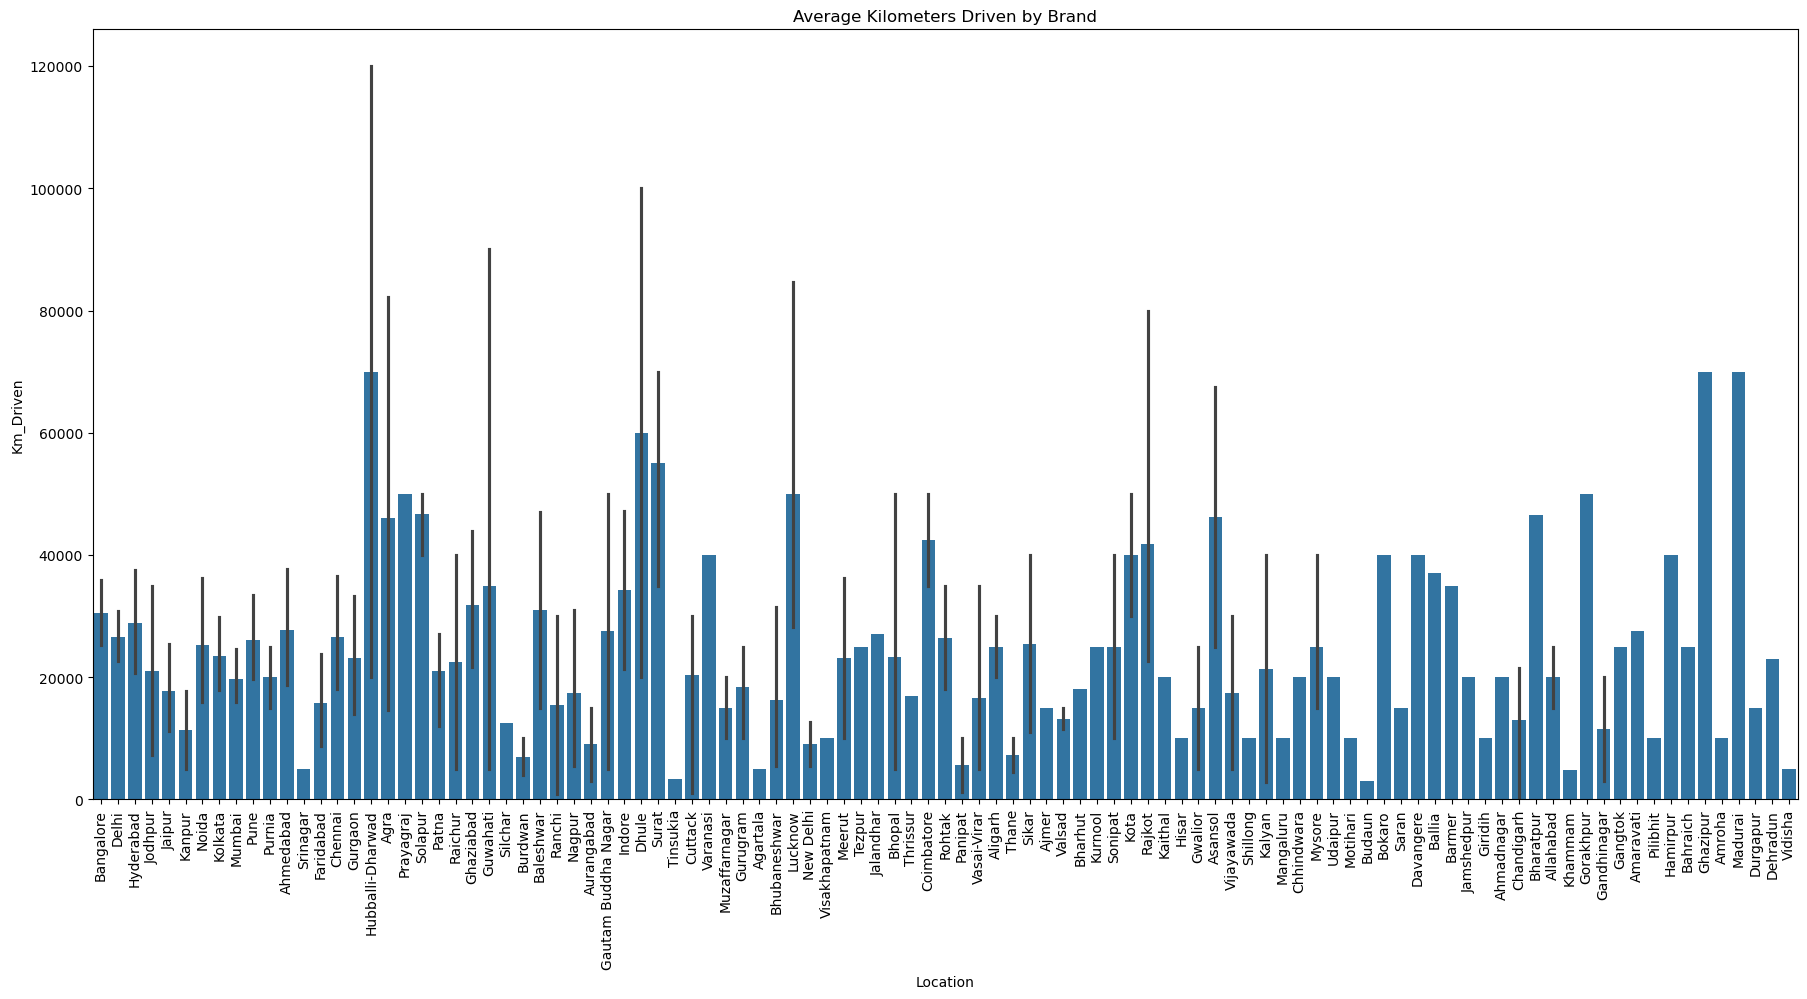

In [25]:
plt.figure(figsize=(22,10))
sns.barplot(x=df['Location'],y=df['Km_Driven'],estimator=np.mean)
plt.xticks(rotation = 90)
plt.title("Average Kilometers Driven by Brand")
plt.show()

In [26]:
df.groupby('Location')['Km_Driven'].describe()

count          mean           std      min      25%      50%  \
Location                                                                      
Agartala         1.0   5000.000000           NaN   5000.0   5000.0   5000.0   
Agra             6.0  46056.833333  45459.368453   3341.0   8750.0  40000.0   
Ahmadnagar       1.0  20000.000000           NaN  20000.0  20000.0  20000.0   
Ahmedabad       16.0  27807.437500  20984.082831   1350.0  10000.0  25301.0   
Ajmer            1.0  15000.000000           NaN  15000.0  15000.0  15000.0   
...              ...           ...           ...      ...      ...      ...   
Varanasi         1.0  40000.000000           NaN  40000.0  40000.0  40000.0   
Vasai-Virar      3.0  16666.666667  16072.751268   5000.0   7500.0  10000.0   
Vidisha          1.0   5000.000000           NaN   5000.0   5000.0   5000.0   
Vijayawada       2.0  17500.000000  17677.669530   5000.0  11250.0  17500.0   
Visakhapatnam    1.0  10000.000000           NaN  10000.0  10000.0  10000.0   

                   75%       max  
Location                          
Agartala        5000.0    5000.0  
Agra           66000.0  120000.0  
Ahmadnagar     20000.0   20000.0  
Ahmedabad      36250.0   80000.0  
Ajmer          15000.0   15000.0  
...                ...       ...  
Varanasi       40000.0   40000.0  
Vasai-Virar    22500.0   35000.0  
Vidisha         5000.0    5000.0  
Vijayawada     23750.0   30000.0  
Visakhapatnam  10000.0   10000.0  

[101 rows x 8 columns]

### Multivariate analysis

**Insights from Model vs Ownership vs Price & Km_Driven**

- First Ownership Premium â€“ Across almost all models, First-owner bikes command the highest average price while maintaining lower average kilometers. Buyers clearly value lower ownership transfers.
- Second/Third Ownership Discount â€“ Prices drop significantly for second/third-owner bikes (e.g., Royal Enfield Classic 350 or Pulsar models), even when their running is not extremely high. Ownership history is a strong price determinant.
- Heavy Outliers in Km_Driven â€“ Some second/third-owner scooters like Access 125 Drum CBS (200,000 km), Splendor Plus i3s (90,000 km), and Honda CD Dawn (100,000 km) reflect extreme running, pulling averages upward.
- Premium Bikes Hold Value â€“ High-end models (e.g., Interceptor 650, Ninja 300, Himalayan) show relatively lower running (5,000â€“15,000 km) and still resell at high prices, indicating stronger demand and slower depreciation.
- Scooters vs Motorcycles â€“ Scooters (Activa, Jupiter, Access, Dio) generally clock lower kilometers (15kâ€“40k) and sell at lower average prices compared to motorcycles. This shows scooters are used more for short city commutes and replaced sooner.
- New Launches & Special Editions â€“ Newer bikes (e.g., XBlade BS4, Xpulse 200 4V, Glamour Xtec, Xoom 110) have very low kilometers (below 5,000 km) and higher resale value, showing quick resale turnover for fresh launches.

**Insights from Price vs Registration_year & Ownership**

- First-owner bikes dominate across all years with relatively stable and reasonable resale prices, while second/third-owner bikes show higher variation and occasional extreme outliers (e.g., â‚¹4.7L in 2019).
- Resale values rise sharply after 2020, with first-owner bikes crossing â‚¹1L+ consistently, reflecting higher demand and pricing for newer models.


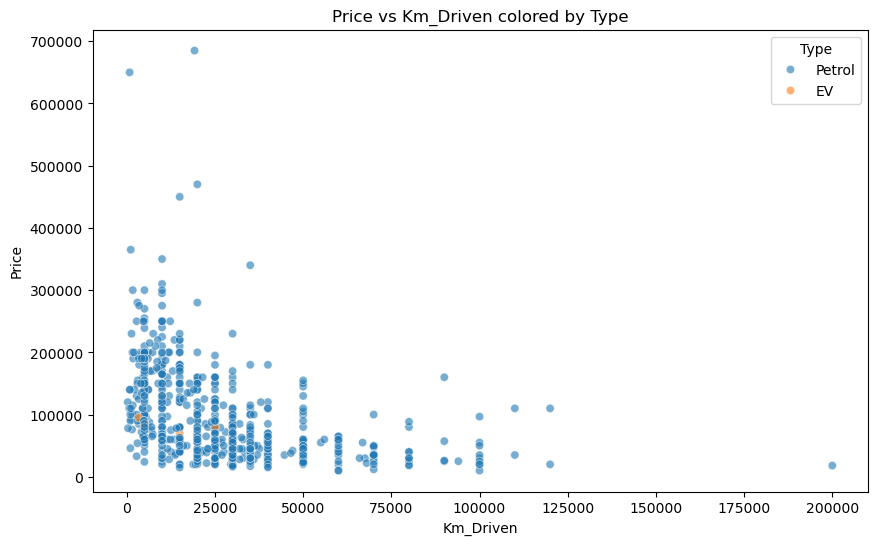

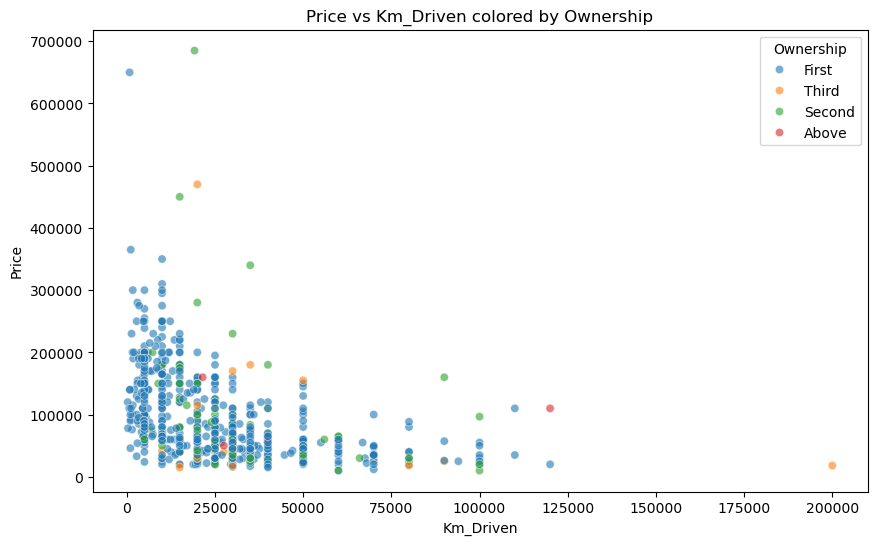

In [56]:
def scatterplot_with_cat(cat_cols):
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Km_Driven', y='Price', hue=col, data=df, alpha=0.6)
        plt.title(f"Price vs Km_Driven colored by {col}")
        plt.show()

# Example usage: pass list of categorical columns
categorical_cols = ['Type', 'Ownership']  # update as per your df
scatterplot_with_cat(categorical_cols)


In [58]:
g = df.groupby(['Model','Ownership'])

In [70]:
g[['Price','Km_Driven']].agg('mean')

Price  \
Model                                              Ownership                  
 Bullet 350 ES ABS BS4                             Above      110000.000000   
                                                   First      135000.000000   
 Bullet 350 Electric Start BS4                     First      145000.000000   
                                                   Second      85000.000000   
 Bullet 350 X Electric Start                       First      187000.000000   
 Bullet 350 X Kick Start                           First      134000.000000   
 Bullet Electra std                                First      111250.000000   
                                                   Second      90000.000000   
 Classic 350 (2012-2021) ABS BS4                   First      107000.000000   
 Classic 350 (2012-2021) Pure Black BS6 January... First      165000.000000   
 Classic 350 (2012-2021) Redditch BS4              Second     115000.000000   
 Classic 350 (2012-2021) STD BS3                   First      120000.000000   
 Classic 350 (2012-2021) Stealth Black BS6 2020    First      175000.000000   
 Classic 350 Chrome Series With Dual-Channel       First      148000.000000   
 Classic 350 Dark Series With Dual-Channel         First      202000.000000   
                                                   Second     175000.000000   
                                                   Third      170000.000000   
 Classic 350 Redditch Series With Single-Channel   First      127500.000000   
                                                   Third      155000.000000   
 Classic 350 Signals Series With Dual-Channel      First      182500.000000   
 Classic 500 Stealth Black                         First      160000.000000   
 Himalayan BS4 ABS                                 First      170000.000000   
 Himalayan Granite Black                           First      250000.000000   
 Himalayan Gravel Grey                             First      200000.000000   
 Himalayan Lake Blue                               First      210000.000000   
 Himalayan Snow White                              Second      96700.000000   
                                                   Third      115000.000000   
 Hunter 350 Metro                                  First      180000.000000   
 Hunter 350 Metro Rebel                            First      164999.500000   
 Interceptor 650 Baker Express                     First      215000.000000   
 Interceptor 650 Black Ray                         First      225000.000000   
 Interceptor 650 Mark Three                        First      250000.000000   
 Interceptor 650 Orange Crush                      First      266666.666667   
 Interceptor 650 Ravishing Red                     First      270000.000000   
 Interceptor 650 Silver Spectre                    First      210000.000000   
 Meteor 350 Fireball                               First      210000.000000   
 Meteor 350 Fireball Custom                        First      200000.000000   
 Meteor 350 Stellar                                First      193333.333333   
 Meteor 350 Stellar Custom                         First      193333.333333   
 Meteor 350 Supernova                              First      180000.000000   
 Thunderbird 350 ABS                               First      105000.000000   
                                                   Second     110000.000000   
 Thunderbird 350 STD                               First       90666.666667   
 Thunderbird 350X ABS                              First      150000.000000   
 Thunderbird 350X STD                              First      111250.000000   
200 Duke                                           First      137500.000000   
200 Duke 2013 â€“ 2016                               First       85000.000000   
                                                   Second      83500.000000   
200 Duke STD 2018 â€“ 2020                           First      152500.000000   
250 Duke 2017-2019                   

In [12]:
temp = pd.pivot_table(
    df,
    index='Ownership',
    columns='Registration_year',
    values='Price',
    aggfunc='mean'
)


In [15]:
df_melted = temp.reset_index().melt(
    id_vars='Ownership',
    var_name='Registration_year',
    value_name='Price'
)

# drop NaNs if you want only valid values
df_melted = df_melted.dropna()
df_melted

Ownership Registration_year          Price
1      First              2007   16000.000000
5      First              2009   29000.000000
9      First              2010   24666.666667
10    Second              2010   17500.000000
11     Third              2010   19000.000000
12     Above              2011   50000.000000
13     First              2011   25750.000000
14    Second              2011   20000.000000
15     Third              2011   18000.000000
17     First              2012   28937.500000
18    Second              2012   25000.000000
19     Third              2012   15000.000000
21     First              2013   44071.428571
22    Second              2013   65000.000000
23     Third              2013   23799.500000
24     Above              2014  110000.000000
25     First              2014   40416.666667
26    Second              2014   72000.000000
27     Third              2014   30000.000000
28     Above              2015   60000.000000
29     First              2015   59068.181818
30    Second              2015  168555.555556
32     Above              2016   49999.000000
33     First              2016   58629.243902
34    Second              2016   61462.500000
35     Third              2016   70000.000000
37     First              2017   70684.250000
38    Second              2017   68500.000000
39     Third              2017   97500.000000
41     First              2018   82009.038462
42    Second              2018   92909.000000
43     Third              2018   87333.333333
44     Above              2019  160000.000000
45     First              2019  124105.263158
46    Second              2019   98333.333333
47     Third              2019  470000.000000
49     First              2020  113630.952381
50    Second              2020   83224.750000
51     Third              2020  170000.000000
53     First              2021  115414.634146
54    Second              2021  112666.666667
57     First              2022  146074.074074
58    Second              2022  186000.000000
61     First              2023  147071.391304
65     First              2024  141750.000000

# ðŸ“Œ Conclusions

- Most two-wheelers in the resale market fall in the affordable segment, with only a small portion being premium bikes.

- Older vehicles tend to have higher usage and significantly lower resale value, while newer models sell quickly at higher prices.

- Vehicles that have been used extensively lose their value much faster, regardless of the brand or category.

- Units that are still with the first owner consistently sell for better prices compared to those with multiple ownership transfers.

- Commuter models dominate the resale market, while sports and premium models occupy a niche but attract enthusiasts.

- Brand reputation plays a strong role: some brands retain their value better due to popularity, demand, and trust.

- Urban markets show higher resale values compared to smaller towns, reflecting stronger demand and spending capacity.

- A few listings show unusually high or low pricing, suggesting either data quality issues or unrealistic seller expectations.

# Overall Takeaway

- The resale market is active and competitive, mainly driven by demand for reliable, low-usage, and first-owner vehicles.

- Buyers show clear preference for newer models with fewer kilometers, while older and heavily used ones are forced into lower price brackets.

- Brand, condition, and location all influence final selling price, making them the key decision factors in the market.

# Recommendations for Sellers

- Highlight good condition and proper maintenance in the listing to attract higher prices.

- If you are the first owner, make sure to mention it clearly â€” it adds strong value.

- Set a realistic price range by comparing with similar models in the market; avoid overpricing.

- Provide complete documents and service history, as buyers trust transparent deals more.

- Selling sooner after purchase (rather than after heavy usage) ensures a much better resale value.

# Recommendations for Buyers

- Prefer newer vehicles with low usage for long-term reliability.

- Look for single-owner bikes â€” they are generally better maintained and less risky.

- Donâ€™t focus only on price; check condition, service records, and accident history.

- Negotiate strongly if the bike has very high usage or multiple previous owners.

- Consider resale potential â€” choose popular brands/models that will hold value in the future.